<a href="https://colab.research.google.com/github/ishanyash/coppett-hill-cs/blob/main/coppett_hill_cs_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Imports: Library + Datasets

In [56]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from collections import Counter
from matplotlib.ticker import FuncFormatter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
from functools import lru_cache
from matplotlib.gridspec import GridSpec

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams.update({'font.size': 12})

# Create necessary directories
os.makedirs('results', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)

## 2. Datasets loading

In [2]:
# Load the datasets
print("Loading datasets...")
bimm_domains = pd.read_csv('BIMM_domains.csv')
bimm_classes = pd.read_excel('bimm_classes.xlsx')
search_domain_traffic = pd.read_csv('organic_search_domain_traffic.csv')
search_keywords = pd.read_csv('organic_search_keywords.csv')
print("All datasets loaded successfully!")

# Display info about the datasets
print(f"BIMM Domains: {bimm_domains.shape[0]} domains")
print(f"BIMM Classes: {bimm_classes.shape[0]} class mappings")
print(f"Search Domain Traffic: {search_domain_traffic.shape[0]} records")
print(f"Search Keywords: {search_keywords.shape[0]} keywords")

Loading datasets...
All datasets loaded successfully!
BIMM Domains: 9 domains
BIMM Classes: 128 class mappings
Search Domain Traffic: 246365 records
Search Keywords: 107804 keywords


## 3. Preprocessing & Cleaning

In [3]:
# Load BIMM domains
bimm_domains_list = bimm_domains['Domain'].tolist()

# Add a new column to search_domain_traffic to indicate BIMM domains
search_domain_traffic['Is_BIMM_Domain'] = search_domain_traffic['Domain'].apply(
    lambda domain: domain in bimm_domains_list
)

In [5]:
# Preprocess the data
print("Preprocessing data...")

# Check for missing values
print("Missing values in BIMM classes:")
print(bimm_classes.isnull().sum())
print("\nMissing values in search keywords:")
print(search_keywords.isnull().sum())
print("\nMissing values in search domain traffic:")
print(search_domain_traffic.isnull().sum())

Preprocessing data...
Missing values in BIMM classes:
Term (part of keyword)    0
Segment                   0
dtype: int64

Missing values in search keywords:
Keyword                    0
Monthly Google searches    0
dtype: int64

Missing values in search domain traffic:
Keyword           92670
Domain            92670
Traffic           92670
Is_BIMM_Domain        0
dtype: int64


In [8]:
null_rows = search_domain_traffic[search_domain_traffic.isnull().any(axis=1)]
null_rows

,Keyword,Domain,Traffic,Is_BIMM_Domain
153695,NaN,NaN,NaN,False
153696,NaN,NaN,NaN,False
153697,NaN,NaN,NaN,False
153698,NaN,NaN,NaN,False
153699,NaN,NaN,NaN,False
...,...,...,...,...
246360,NaN,NaN,NaN,False
246361,NaN,NaN,NaN,False
246362,NaN,NaN,NaN,False
246363,NaN,NaN,NaN,False




---


Dataframe "search_domain_traffic" had 92670 rows with null value, and with further confirmation, we can say its safe to drop them from the dataframe.

---



In [9]:
search_domain_traffic = search_domain_traffic.dropna()
search_domain_traffic.shape

(153695, 4)

In [146]:
search_domain_traffic[search_domain_traffic['Is_BIMM_Domain'] == False].shape

(151743, 4)

In [145]:
search_domain_traffic[search_domain_traffic['Is_BIMM_Domain'] == True].shape

(1952, 4)

### Functions

In [10]:
# Clean search text function
def clean_search_text(search_text):
    """
    Clean a search text by removing unnecessary characters and standardising format
    """
    if not isinstance(search_text, str):
        return ""

    # Convert to lowercase
    clean_text = search_text.lower()

    # Remove extra spaces
    clean_text = ' '.join(clean_text.split())

    # Remove special characters except word-forming ones
    clean_text = re.sub(r'[^\w\s\-\+]', ' ', clean_text)

    # Replace multiple spaces with single space
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()

    return clean_text

In [11]:
# Clean search keywords
search_keywords['Keyword_Clean'] = search_keywords['Keyword'].apply(clean_search_text)

# Display example of cleaned keywords
print("\nExample of cleaned keywords:")
search_keywords[['Keyword', 'Keyword_Clean']].head()


Example of cleaned keywords:


,Keyword,Keyword_Clean
0,lamda syllabus,lamda syllabus
1,lee actor,lee actor
2,music academy london,music academy london
3,stockingshq media,stockingshq media
4,christian actor,christian actor




---


Just a precautionary measure, I can see most of the dataset is clean

---



In [12]:
# Create initial term-to-segment mapping
def create_segment_terms(bimm_classes):
    """
    Create initial term-to-segment mapping from BIMM classes dataset
    """
    segment_terms = {}

    # Process each term in the classes dataset
    for _, row in bimm_classes.iterrows():
        term = str(row['Term (part of keyword)']).lower()
        segment = row['Segment']

        # Add to segment-terms dictionary
        if segment not in segment_terms:
            segment_terms[segment] = []

        segment_terms[segment].append(term)

    return segment_terms

# Expand segment terms with additional domain knowledge
def expand_segment_terms(segment_terms):
    """
    Add additional related terms to each segment based on domain knowledge
    """
    # Create a copy to avoid modifying the original
    expanded_terms = {k: list(v) for k, v in segment_terms.items()}

    # Add more performing arts terms
    # These terms determine what keywords will be classified as "performing arts"
    # Adding terms expands coverage, removing terms restricts it
    expanded_terms['performing arts'].extend([
        'theatre', 'theater', 'acting', 'actor', 'actress', 'stage',
        'drama', 'ballet', 'dance', 'dancer', 'choreography', 'musical',
        'performance', 'opera', 'mime', 'improv', 'improvisation',
        'drama school', 'choreographer', 'performing', 'performer', 'perform',
        'dancers', 'actors', 'actresses', 'theatrical', 'dramatics',
        'dramatical', 'dancing', 'contemporary dance', 'contemporary',
        'jazz dance', 'tap dance', 'choreographed', 'audition', 'rehearsal',
        'stage manager', 'stage management', 'movement', 'voice', 'monologue',
        'dialogue', 'character', 'costume', 'set design', 'lighting', 'prop',
        'makeup', 'performance art', 'live art', 'theater', 'theatre'
    ])

    # Add more music terms
    # These terms determine what keywords will be classified as "music"
    # Adding terms expands coverage, removing terms restricts it
    expanded_terms['music'].extend([
        'music production', 'producer', 'audio', 'sound', 'recording',
        'mixing', 'mastering', 'studio', 'band', 'song', 'songwriting',
        'guitar', 'piano', 'vocals', 'singing', 'bass', 'drums',
        'electronic', 'dj', 'ableton', 'logic', 'protools', 'album',
        'composition', 'composer', 'orchestra', 'ensemble', 'choir',
        'vocalist', 'instrumental', 'synthesizer', 'daw', 'performance',
        'concert', 'gig', 'tour', 'festival', 'session', 'arrangement',
        'harmony', 'melody', 'rhythm', 'beat', 'bassline', 'groove',
        'classical', 'jazz', 'conservatory', 'conservatoire', 'recital',
        'musician', 'recording studio', 'record label', 'music business',
        'industry', 'producing', 'sound design', 'sound engineering', 'acoustic',
        'concert', 'musical', 'symphony', 'opera', 'score', 'conductor'
    ])

    # Add more film terms
    # These terms determine what keywords will be classified as "film"
    # Adding terms expands coverage, removing terms restricts it
    expanded_terms['film'].extend([
        'cinema', 'movie', 'director', 'production', 'documentary',
        'cinematography', 'camera', 'filming', 'editing', 'post-production',
        'screenplay', 'script', 'filmmaker', 'filmmaking', 'video', 'animation',
        'directing', 'producer', 'short film', 'narrative', 'visual effects',
        'vfx', 'special effects', 'sfx', 'color grading', 'storyboard',
        'shot list', 'call sheet', 'film set', 'location', 'studio',
        'digital film', 'screenwriter', 'direction', 'producing',
        'film school', 'cinema studies', 'motion picture', 'feature film',
        'documentary', 'screenwriting', 'directing', 'cinematographer',
        'animation', '3d animation', 'motion graphics', 'videography',
        'director of photography', 'dp', 'gaffer', 'grip', 'sound design',
        'sound recording', 'film score', 'production design', 'art direction'
    ])

    # Add more gaming terms
    # These terms determine what keywords will be classified as "gaming"
    # Adding terms expands coverage, removing terms restricts it
    expanded_terms['gaming'].extend([
        'game design', 'game development', 'game art', 'unity',
        'unreal', 'character design', 'level design', 'game programming',
        'game studio', 'developer', 'indie', 'esports',
        'videogame', 'video game', 'game engine', 'game mechanics',
        'gaming', 'gamer', 'gamers', 'gameplay', 'game play',
        '3d modeling', '3d modelling', 'level designer', 'game developer',
        'game audio', 'game music', 'game sound', 'esport', 'e-sport',
        'game character', 'game environment', 'game world', 'gaming industry',
        'game tester', 'game testing', 'game quality assurance', 'game qa',
        'interactive media', 'game narrative', 'game writing', 'game script',
        'programmer', 'coding', 'software development', 'game production',
        'concept art', 'animation', 'rigging', 'game engine', 'multiplayer',
        'console', 'virtual reality', 'vr', 'augmented reality', 'ar',
        'game design document', 'gdd', 'game designer', 'game developer'
    ])

    # Add more course terms
    # These terms determine what keywords will be classified as "course"
    # Adding terms expands coverage, removing terms restricts it
    expanded_terms['course'].extend([
        'program', 'training', 'workshop', 'seminar', 'intensive',
        'certificate', 'certification', 'diploma', 'short course',
        'education', 'learning', 'teaching', 'module',
        'seminars', 'tutorials', 'programmes',
        'programs', 'courses', 'bootcamp', 'masterclass',
        'lecture', 'practical', 'hands-on', 'skills', 'vocational',
        'continuing professional development', 'cpd', 'professional development',
        'summer course', 'weekend course', 'foundation course',
        'training program', 'continuing education'
    ])

    # Add more degree terms
    # These terms determine what keywords will be classified as "degree"
    # Adding terms expands coverage, removing terms restricts it
    expanded_terms['degree'].extend([
        'ba', 'bsc', 'ma', 'msc', 'mfa', 'phd', 'bachelor', 'master',
        'undergraduate', 'postgraduate', 'higher education',
        'undergraduate degree', 'postgraduate degree', 'graduate degree',
        'academic', 'academia', 'graduation', 'thesis', 'dissertation',
        'semester', 'term', 'year', 'credit', 'module', 'elective',
        'major', 'minor', 'specialization', 'concentration'
    ])

    return expanded_terms

---


These functions, specially 'expand_segment_terms' were made after multiple back and forth analysis of the datasets, specially in order to understand what words can be added in the expanded term list.


---


In [13]:
# Create the segment mapping
segment_terms = create_segment_terms(bimm_classes)
print("Number of terms per segment (initial):")
for segment, terms in segment_terms.items():
    print(f"{segment}: {len(terms)} terms")

Number of terms per segment (initial):
course: 5 terms
degree: 36 terms
film: 30 terms
gaming: 13 terms
music: 28 terms
performing arts: 16 terms


In [14]:
# Expand the segment terms
expanded_segment_terms = expand_segment_terms(segment_terms)
print("\nNumber of terms per segment (expanded):")
for segment, terms in expanded_segment_terms.items():
    print(f"{segment}: {len(terms)} terms (added {len(terms) - len(segment_terms[segment])} new terms)")


Number of terms per segment (expanded):
course: 38 terms (added 33 new terms)
degree: 65 terms (added 29 new terms)
film: 86 terms (added 56 new terms)
gaming: 73 terms (added 60 new terms)
music: 93 terms (added 65 new terms)
performing arts: 68 terms (added 52 new terms)


In [15]:
 def is_institution_specific(search_text):
    """
    Check if a search text refers to a specific university/institution
    """
    search_text_lower = search_text.lower()

    # Strong institution indicators - these patterns directly indicate an institution
    # Adding patterns makes detection more strict, removing patterns makes it more lenient
    strong_indicators = [
        r'university of \w+',       # "university of edinburgh"
        r'\w+ university\b',        # "edinburgh university"
        r'\broyal academy\b',       # "royal academy of music"
        r'\broyal college\b',       # "royal college of art"
        r'\broyal school(s)?\b',    # "royal school of music", "royal schools of music"
        r'\bconservatoire\b',       # "trinity conservatoire"
        r'\w+ (school|college|academy|institute|conservatory)\b',  # "point blank music school"
        r'\blecture theatre\b',     # "gordon aikman lecture theatre"
        r'\b(gordon aikman)\b',     # specific named location
        r'\bsfx colleges?\b',
        r'\bucl\b', r'\bual\b',     # specific university acronyms
        r'\bgoldsmiths\b',
        r'\boxford\b', r'\bcambridge\b',
        r'\bpoint blank\b',         # specific institution name
        r'\bblackboard\b', r'\bcanvas\b', r'\bmoodle\b',  # learning platforms
        r'\buniversity\s',          # university followed by a space
        r'\s(uni)\b',               # standalone "uni" preceded by a space
        r'\bcollege\s',             # college followed by a space
        r'\bcampus\b',              # campus
        r'\bfaculty\b',             # faculty
        r'\bdepartment\b',          # department
        r'\binstitute\b',           # institute
        r'\bschool of\b',           # school of
        r'\bbest \w+ schools\b',    # "best film schools"
        r'\btop \w+ schools\b',     # "top music schools"
        r'\bnational\s+\w+\s+(school|college|academy)\b'  # "national film school"
    ]

    # Check for strong indicators
    for pattern in strong_indicators:
        if re.search(pattern, search_text_lower):
            return True

    # List of specific institution names and cities with major institutions
    # Adding names increases detection, removing names decreases it
    institution_names = [
        'edinburgh', 'liverpool', 'manchester', 'glasgow', 'bristol',
        'leeds', 'birmingham', 'hull', 'cardiff', 'exeter', 'sussex',
        'kent', 'essex', 'newcastle', 'sheffield', 'southampton', 'coventry',
        'trinity', 'imperial', 'kings', "king's", 'queens', "queen's", 'lse',
        'warwick', 'durham', 'bath', 'leicester', 'nottingham', 'lancaster',
        'aberdeen', 'dundee', 'stirling', 'heriot', 'napier', 'strathclyde',
        'guildhall', 'rada', 'lamda', 'central', 'cssd', 'bournemouth', 'brighton',
        'point blank', 'sfx', 'gordon aikman', 'national film', 'television school'
    ]

    # Educational term indicators - these combined with institution names indicate institution-specific contexts
    # Adding terms increases detection, removing terms decreases it
    education_terms = [
        'university', 'college', 'school', 'academy', 'institute', 'faculty',
        'campus', 'department', 'student', 'undergraduate', 'postgraduate',
        'lecturer', 'professor', 'tutor', 'course', 'module', 'program', 'degree'
    ]

    # Check for institution name combined with educational term
    for name in institution_names:
        if name in search_text_lower:
            for term in education_terms:
                if term in search_text_lower:
                    # Check for proximity between institution name and educational term
                    name_followed_by_term = re.search(r'\b' + re.escape(name) + r'\s+\w*\s*' + re.escape(term), search_text_lower)
                    term_followed_by_name = re.search(r'\b' + re.escape(term) + r'\s+\w*\s*' + re.escape(name), search_text_lower)

                    if name_followed_by_term or term_followed_by_name:
                        return True

    return False

In [16]:
def filter_out_non_educational(search_text, segment):
    """
    Filter out search texts that match a segment's subject area but aren't about education
    or contain potentially inappropriate content

    This function determines what gets excluded from educational segments
    """
    search_text_lower = search_text.lower()

    # Handle adult content - "for adults" is legitimate, but standalone "adult" may be inappropriate
    # This differentiates between legitimate adult education and potential adult content
    if 'adult' in search_text_lower:
        # Legitimate adult education patterns - adding patterns increases acceptance
        legitimate_patterns = [
            r'for adults',
            r'adult ballet classes',
            r'adult dance classes',
            r'adult acting classes',
            r'adult music classes',
            r'adult drama classes',
            r'mature students'
        ]

        # Check if it matches legitimate patterns
        is_legitimate = any(re.search(pattern, search_text_lower) for pattern in legitimate_patterns)

        # If it contains "adult" but doesn't match legitimate patterns, consider it Non-Educational
        if not is_legitimate:
            return True

    # Check based on segment subject
    if 'Music' in segment:
        # Music-specific non-educational patterns - adding patterns increases exclusion
        non_ed_patterns = [
            r'help you study',
            r'helps with study',
            r'study with music',
            r'studying with music',
            r'music for studying',
            r'music while studying',
            r'background music',
            r'\bstudymusic\b',
            # Engineering terms not related to music production
            r'software engineering',
            r'electrical engineering',
            r'civil engineering',
            r'mechanical engineering',
            r'engineering degree(?! in music)',  # Engineering degree not specifically for music
            r'engineering course(?! in music)'   # Engineering course not specifically for music
        ]

        for pattern in non_ed_patterns:
            if re.search(pattern, search_text_lower):
                return True

    elif 'Film' in segment:
        # Film-specific non-educational patterns - adding patterns increases exclusion
        non_ed_patterns = [
            r'where to watch',
            r'streaming',
            r'movie times',
            r'cinema near',
            r'tickets for'
        ]

        for pattern in non_ed_patterns:
            if re.search(pattern, search_text_lower):
                return True

    elif 'Gaming' in segment:
        # Gaming-specific non-educational patterns - adding patterns increases exclusion
        non_ed_patterns = [
            r'\bplay\b',
            r'\bonline games\b',
            r'\bfree games\b',
            r'\bgame reviews\b',
            r'\bgame cheats\b',
            r'\bschool games\b',
            r'\bschoolgames\b',
            r'\bgames for school\b',
            r'\beducational games\b',
            r'\bclassroom games\b'
        ]

        for pattern in non_ed_patterns:
            if re.search(pattern, search_text_lower):
                return True

    return False



---


There was a need to create multiple segments which might be useful for the client in the future. Therefore, in order to segregate institution specific keywords, I devised a way to get this process standardised into functions which assign them to new segments like 'Institution Specific' and 'Non Educational'. The aim was to focus on high potential enquiry conversion.

---



### Initial Segmentation function

In [22]:
def contains_segment_terms(search_text, segment_terms_list, min_confidence=0.6):
    """
    Check if a search text contains any terms from a segment with improved context awareness

    This function determines the strength of a match between a keyword and a segment
    Adjusting min_confidence affects how strict the matching is
    """
    search_text_lower = search_text.lower()

    # Track match confidence
    max_confidence = 0.0

    for term in segment_terms_list:
        # Short term handling with word boundaries (more strict for short terms)
        if len(term) <= 3:
            pattern = r'\b' + re.escape(term) + r'\b'
            if re.search(pattern, search_text_lower):
                if term in ['ba', 'ma', 'phd', 'mfa', 'msc', 'bsc']:  # Strong degree indicators
                    max_confidence = max(max_confidence, 0.95)
                else:
                    max_confidence = max(max_confidence, 0.7)

        # Medium term handling (4-6 chars)
        elif 4 <= len(term) <= 6:
            pattern = r'\b' + re.escape(term) + r'\b'
            if re.search(pattern, search_text_lower):
                max_confidence = max(max_confidence, 0.85)
            elif term in search_text_lower:  # Partial match for medium terms
                max_confidence = max(max_confidence, 0.6)

        # Longer term handling (more reliable)
        else:
            # Try exact words match first
            pattern = r'\b' + re.escape(term) + r'\b'
            if re.search(pattern, search_text_lower):
                max_confidence = max(max_confidence, 0.95)
            # Then try whole phrase match
            elif term in search_text_lower:
                max_confidence = max(max_confidence, 0.8)
            # For multi-word terms, check if majority of words are present
            elif ' ' in term:
                term_words = term.split()
                matched_words = sum(1 for word in term_words if re.search(r'\b' + re.escape(word) + r'\b', search_text_lower))
                if matched_words / len(term_words) >= 0.7:  # At least 70% of words match
                    max_confidence = max(max_confidence, 0.7)

    return max_confidence >= min_confidence

def categorize_search_text(search_text, segment_terms, context_filters=None):
    """
    Categorize a search text into one or more of the eight segments with improved context awareness

    This function applies the actual segment categorization rules
    """
    segments = []

    # Apply additional context-based filtering if provided
    if context_filters:
        # Skip music for studying terms
        if 'is_generic_educational_query' in context_filters and context_filters['is_generic_educational_query'](search_text):
            return []

        # Skip school games and similar non-video game terms
        if 'is_gaming_relevant' in context_filters and 'gaming' in segment_terms:
            if not context_filters['is_gaming_relevant'](search_text) and any(term in search_text.lower() for term in ['game', 'games', 'gaming']):
                return []

    # Check for Film + Course
    if (contains_segment_terms(search_text, segment_terms.get('film', [])) and
        contains_segment_terms(search_text, segment_terms.get('course', []))):
        segments.append('Film + Course')

    # Check for Film + Degree
    if (contains_segment_terms(search_text, segment_terms.get('film', [])) and
        contains_segment_terms(search_text, segment_terms.get('degree', []))):
        segments.append('Film + Degree')

    # Check for Gaming + Course
    if (contains_segment_terms(search_text, segment_terms.get('gaming', [])) and
        contains_segment_terms(search_text, segment_terms.get('course', []))):
        segments.append('Gaming + Course')

    # Check for Gaming + Degree
    if (contains_segment_terms(search_text, segment_terms.get('gaming', [])) and
        contains_segment_terms(search_text, segment_terms.get('degree', []))):
        segments.append('Gaming + Degree')

    # Check for Performing arts + Course
    if (contains_segment_terms(search_text, segment_terms.get('performing arts', [])) and
        contains_segment_terms(search_text, segment_terms.get('course', []))):
        segments.append('Performing arts + Course')

    # Check for Performing arts + Degree
    if (contains_segment_terms(search_text, segment_terms.get('performing arts', [])) and
        contains_segment_terms(search_text, segment_terms.get('degree', []))):
        segments.append('Performing arts + Degree')

    # Check for Music + Course
    if (contains_segment_terms(search_text, segment_terms.get('music', [])) and
        contains_segment_terms(search_text, segment_terms.get('course', []))):
        segments.append('Music + Course')

    # Check for Music + Degree
    if (contains_segment_terms(search_text, segment_terms.get('music', [])) and
        contains_segment_terms(search_text, segment_terms.get('degree', []))):
        segments.append('Music + Degree')

    return segments

# Additional context filters
def is_generic_educational_query(search_text):
    """
    Check for music study queries that aren't about studying music as a subject
    """
    search_text_lower = search_text.lower()
    generic_ed_patterns = [
        r'does \w+ help (you )?study',  # "does music help you study"
        r'help[s]? (with )?study(ing)?', # "music helps with studying"
        r'study(ing)? with \w+',  # "studying with music"
        r'study music',           # "study music" as in "music to study to"
        r'for study(ing)?',       # "music for studying"
        r'while study(ing)?',     # "music while studying"
        r'background \w+',        # "background music"
        r'\bstudymusic\b',        # "studymusic" (no space)
    ]
    return any(re.search(pattern, search_text_lower) for pattern in generic_ed_patterns)

def is_gaming_relevant(search_text):
    """
    Check if a search text is actually about video gaming (not educational games)
    """
    search_text_lower = search_text.lower()
    school_game_patterns = [
        r'\bschool\s?games\b',   # "school games" or "schoolgames"
        r'\bgames\s?for\s?school\b',
        r'\beducational\s?games\b',
        r'\bclassroom\s?games\b',
        r'\bschool\s?activities\b'
    ]
    if any(re.search(pattern, search_text_lower) for pattern in school_game_patterns):
        return False

    gaming_specific_terms = ['video game', 'videogame', 'game design', 'game development']
    return any(term in search_text_lower for term in gaming_specific_terms)

# Perform initial segmentation
print("Performing initial segmentation...")
context_filters = {
    'is_generic_educational_query': is_generic_educational_query,
    'is_gaming_relevant': is_gaming_relevant
}

search_keywords['Initial_Segments'] = search_keywords['Keyword_Clean'].apply(
    lambda text: categorize_search_text(text, expanded_segment_terms, context_filters)
)

# Count search texts by initial segment
initial_segment_counts = {
    'Film + Course': 0,
    'Film + Degree': 0,
    'Gaming + Course': 0,
    'Gaming + Degree': 0,
    'Performing arts + Course': 0,
    'Performing arts + Degree': 0,
    'Music + Course': 0,
    'Music + Degree': 0,
    'Other': 0
}

for _, row in search_keywords.iterrows():
    segments = row['Initial_Segments']
    if not segments:
        initial_segment_counts['Other'] += 1
    else:
        for segment in segments:
            initial_segment_counts[segment] += 1

print("\nInitial search text counts by segment:")
for segment, count in initial_segment_counts.items():
    print(f"{segment}: {count}")

Performing initial segmentation...

Initial search text counts by segment:
Film + Course: 222
Film + Degree: 248
Gaming + Course: 70
Gaming + Degree: 48
Performing arts + Course: 157
Performing arts + Degree: 299
Music + Course: 181
Music + Degree: 301
Other: 106486


### Applying the filters

In [23]:
# Institution-specific filtering
search_keywords['Is_Institution_Specific'] = search_keywords['Keyword_Clean'].apply(is_institution_specific)

# Generic academic terms filtering
search_keywords['Is_Generic_Academic'] = search_keywords['Keyword_Clean'].apply(
    lambda x: any(term in x.lower() for term in [
        'research proposal', 'dissertation proposal', 'student ambassador',
        'engineering course', 'engineering degree', 'software engineering',
        'electrical engineering'
    ]) and not any(term in x.lower() for term in [
        'audio engineering', 'sound engineering', 'music engineering'
    ])
)

# Non-educational filtering including adult content handling
search_keywords['Non_Educational'] = search_keywords.apply(
    lambda row: filter_out_non_educational(row['Keyword_Clean'],
                                         row['Initial_Segments'][0] if row['Initial_Segments'] else 'Other')
    if len(row['Initial_Segments']) > 0 else False,
    axis=1
)

In [25]:
# Count results of various filters
institution_count = search_keywords['Is_Institution_Specific'].sum()
academic_count = search_keywords['Is_Generic_Academic'].sum()
non_ed_count = search_keywords['Non_Educational'].sum()

print(f"Institution-specific keywords: {institution_count} ({institution_count/len(search_keywords)*100:.2f}%)")
print(f"Generic academic keywords: {academic_count} ({academic_count/len(search_keywords)*100:.2f}%)")
print(f"Non-educational keywords: {non_ed_count} ({non_ed_count/len(search_keywords)*100:.2f}%)")

Institution-specific keywords: 9289 (8.62%)
Generic academic keywords: 208 (0.19%)
Non-educational keywords: 15 (0.01%)


In [26]:
# Sample of filtered keywords
print("\nSample of institution-specific keywords:")
print(search_keywords[search_keywords['Is_Institution_Specific']].sample(5)[['Keyword', 'Initial_Segments']])

print("\nSample of generic academic keywords:")
print(search_keywords[search_keywords['Is_Generic_Academic']].sample(5)[['Keyword', 'Initial_Segments']])

print("\nSample of non-educational keywords:")
print(search_keywords[search_keywords['Non_Educational']].sample(5)[['Keyword', 'Initial_Segments']])


Sample of institution-specific keywords:
                                          Keyword Initial_Segments
83375  liverpool university student accommodation               []
19470              edinburgh university edinburgh               []
18569                       library edinburgh uni               []
76554                how many weeks in a uni term               []
94966             anglia ruskin university photos               []

Sample of generic academic keywords:
                             Keyword Initial_Segments
55793  examples of research proposal               []
67579     example research proposals               []
67118    software engineering degree               []
45159       research proposal sample               []
30217     msc electrical engineering               []

Sample of non-educational keywords:
                         Keyword  Initial_Segments
31205   music engineering course  [Music + Course]
31358  music engineering courses  [Music + Course]
3121

### TF-IDF

In [27]:
# Build corpus for TF-IDF similarity resolution
def build_segment_corpus(segment, expanded_segment_terms, keyword_list=None):
    """
    Build a rich corpus for a segment to improve TF-IDF matching

    The corpus quality affects how accurately multi-segment keywords are resolved
    """
    # Split the segment to get the subject and qualification
    parts = segment.split(' + ')
    subject = parts[0].lower()
    qualification = parts[1].lower()

    # Get relevant terms
    terms = []

    # Add subject-specific terms
    if subject == 'film':
        terms.extend(expanded_segment_terms['film'])
    elif subject == 'music':
        terms.extend(expanded_segment_terms['music'])
    elif subject == 'gaming':
        terms.extend(expanded_segment_terms['gaming'])
    elif subject == 'performing arts':
        terms.extend(expanded_segment_terms['performing arts'])

    # Add qualification terms
    if qualification == 'course':
        terms.extend(expanded_segment_terms['course'])
    elif qualification == 'degree':
        terms.extend(expanded_segment_terms['degree'])

    # Add actual segment keywords if available
    if keyword_list:
        terms.extend(keyword_list)

    # Join all terms into a single corpus
    return ' '.join(terms)

# Function to get best segment using TF-IDF
def get_best_segment_tfidf(keyword, segments, vectorizer, tfidf_matrix, segment_names):
    """
    Determine the best segment for a keyword using TF-IDF similarity

    This helps resolve multi-segment keywords more accurately
    """
    # Transform the keyword
    keyword_vector = vectorizer.transform([keyword])

    # Calculate similarity with each segment
    similarities = cosine_similarity(keyword_vector, tfidf_matrix).flatten()

    # Get similarity scores for relevant segments only
    segment_similarities = {}
    for segment in segments:
        if segment in segment_names:
            segment_idx = segment_names.index(segment)
            segment_similarities[segment] = similarities[segment_idx]

    # If no similarities found, return the first segment (fallback)
    if not segment_similarities:
        return segments[0]

    # Apply context-aware boosting based on strong segment indicators
    keyword_lower = keyword.lower()

    # Boost subject-specific scores based on strong indicators
    for segment, score in segment_similarities.items():
        # Film-specific boost
        if segment.startswith('Film') and any(term in keyword_lower for term in
                                            ['cinema', 'movie', 'film school', 'filmmaking', 'director']):
            segment_similarities[segment] = score * 1.2

        # Music-specific boost
        elif segment.startswith('Music') and any(term in keyword_lower for term in
                                               ['music school', 'conservatory', 'orchestra', 'band', 'audio engineering']):
            segment_similarities[segment] = score * 1.2

        # Gaming-specific boost
        elif segment.startswith('Gaming') and any(term in keyword_lower for term in
                                                ['game design', 'game development', 'game programming', 'esports']):
            segment_similarities[segment] = score * 1.2

        # Performing arts-specific boost
        elif segment.startswith('Performing arts') and any(term in keyword_lower for term in
                                                         ['drama school', 'acting school', 'theatre school', 'dance']):
            segment_similarities[segment] = score * 1.2

    # Return segment with highest score
    return max(segment_similarities.items(), key=lambda x: x[1])[0]

# Resolve multi-segment keywords
print("\nResolving multi-segment keywords...")

# Create segment-specific corpora for TF-IDF
segment_corpora = {}
valid_segments = ['Film + Course', 'Film + Degree', 'Gaming + Course', 'Gaming + Degree',
                 'Performing arts + Course', 'Performing arts + Degree', 'Music + Course', 'Music + Degree']

for segment in valid_segments:
    # Get single-segment keywords to enhance the corpus
    segment_keywords = search_keywords[
        (search_keywords['Initial_Segments'].apply(lambda x: isinstance(x, list) and len(x) == 1 and segment in x)) &
        (~search_keywords['Is_Institution_Specific']) &
        (~search_keywords['Is_Generic_Academic']) &
        (~search_keywords['Non_Educational'])
    ]['Keyword_Clean'].tolist()

    # Build a rich corpus for this segment
    corpus = build_segment_corpus(segment, expanded_segment_terms, segment_keywords)
    segment_corpora[segment] = corpus

# Build TF-IDF model
corpus_list = list(segment_corpora.values())
segment_names = list(segment_corpora.keys())

vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=lambda x: x.split(),
    preprocessor=lambda x: x,
    token_pattern=None,
    stop_words='english',
    min_df=1
)

# Fit the model
tfidf_matrix = vectorizer.fit_transform(corpus_list)

# Create a new column for the resolved segment
search_keywords['Resolved_Segment'] = None

# Resolve each keyword
multi_segment_count = 0
print("Categorizing keywords...")

for idx, row in search_keywords.iterrows():
    segments = row['Initial_Segments']
    is_institution = row['Is_Institution_Specific']
    is_generic = row['Is_Generic_Academic']
    is_non_educational = row['Non_Educational']

    if is_institution:
        search_keywords.at[idx, 'Resolved_Segment'] = 'Institution-Specific'
    elif is_generic:
        search_keywords.at[idx, 'Resolved_Segment'] = 'Academic-Generic'
    elif is_non_educational:
        search_keywords.at[idx, 'Resolved_Segment'] = 'Non-Educational'
    elif not segments:
        search_keywords.at[idx, 'Resolved_Segment'] = 'Other'
    elif len(segments) == 1:
        search_keywords.at[idx, 'Resolved_Segment'] = segments[0]
    else:
        # This is a multi-segment keyword
        multi_segment_count += 1
        best_segment = get_best_segment_tfidf(
            row['Keyword_Clean'],
            segments,
            vectorizer,
            tfidf_matrix,
            segment_names
        )
        search_keywords.at[idx, 'Resolved_Segment'] = best_segment

print(f"Resolved {multi_segment_count} multi-segment keywords using TF-IDF")

# Count by resolved segment
resolved_segment_counts = search_keywords['Resolved_Segment'].value_counts()
print("\nKeywords by resolved segment:")
print(resolved_segment_counts)


Resolving multi-segment keywords...
Categorizing keywords...
Resolved 142 multi-segment keywords using TF-IDF

Keywords by resolved segment:
Resolved_Segment
Other                       97362
Institution-Specific         9289
Academic-Generic              203
Film + Course                 169
Music + Degree                164
Performing arts + Degree      151
Music + Course                140
Performing arts + Course      128
Film + Degree                 123
Gaming + Course                48
Gaming + Degree                15
Non-Educational                12
Name: count, dtype: int64


In [117]:
# Apply pattern-based corrections for keyword misclassifications
def manual_corrections(search_keywords_segmented):
    """
    Apply pattern-based corrections for keyword misclassifications

    This improved function uses partial keyword matching to handle similar keywords efficiently.
    Instead of listing each exact keyword, it uses patterns to match multiple related keywords.

    The function is used for:
    1. Fixing misclassifications that consistently occur
    2. Handling special cases not caught by regular patterns
    3. Ensuring problematic keywords are properly categorized

    Pattern matching allows for more efficient maintenance and broader coverage.
    """
    print("Applying pattern-based corrections...")

    # Pattern-based corrections
    pattern_corrections = [
        # Study music related terms (not educational)
        {'pattern': 'study music', 'segment': 'Non-Educational'},
        {'pattern': 'music for studying', 'segment': 'Non-Educational'},
        {'pattern': 'music study', 'segment': 'Non-Educational'},
        {'pattern': 'music help you study', 'segment': 'Non-Educational'},
        {'pattern': 'classical music study', 'segment': 'Non-Educational'},

        # School games (not gaming education)
        {'pattern': 'school games', 'segment': 'Non-Educational'},
        {'pattern': 'games for school', 'segment': 'Non-Educational'},

        # Social media courses
        {'pattern': 'social media', 'segment': 'Non-Educational'},

        # Property development
        {'pattern': 'property development', 'segment': 'Non-Educational'},
        {'pattern': 'property', 'segment': 'Non-Educational'},

        # Medical/health terms mistaken for music or other segments
        {'pattern': 'ultrasound', 'segment': 'Other'},
        {'pattern': 'audiology', 'segment': 'Other'},

        # Engineering courses that aren't music engineering
        {'pattern': 'engineering', 'segment': 'Other'},
        {'pattern': 'software dev', 'segment': 'Other'},
        {'pattern': 'programme director', 'segment': 'Other'},
        {'pattern': 'yearly records of events in chronological order', 'segment': 'Other'},
        {'pattern': 'operations management', 'segment': 'Other'},

        # Institution-specific terms
        {'pattern': 'lecture theatre', 'segment': 'Institution-Specific'},
        {'pattern': 'royal schools of music', 'segment': 'Institution-Specific'},
        {'pattern': 'point blank music school', 'segment': 'Institution-Specific'},
        {'pattern': 'national film and television school', 'segment': 'Institution-Specific'},
        {'pattern': 'london film school', 'segment': 'Institution-Specific'},
        {'pattern': 'sfx colleges', 'segment': 'Institution-Specific'},
        {'pattern': ' edinburgh theological seminary', 'segment': 'Institution-Specific'},


        # Other non-educational terms
        {'pattern': 'adult dance class', 'segment': 'Non-Educational'},
        {'pattern': 'coding bootcamp', 'segment': 'Non-Educational'},
        {'pattern': 'academic transcript', 'segment': 'Non-Educational'},
        {'pattern': 'psychological studies', 'segment': 'Non-Educational'},
        {'pattern': 'bob learning on screen', 'segment': 'Non-Educational'},
        {'pattern': 'perioperative cpd', 'segment': 'Non-Educational'}
    ]


    # Apply pattern-based corrections
    correction_count = 0

    # Create a copy of the dataframe to track corrections
    original_segments = search_keywords_segmented['Segment'].copy()

    # Apply each pattern correction
    for correction in pattern_corrections:
        pattern = correction['pattern'].lower()
        new_segment = correction['segment']

        # Find keywords containing the pattern
        mask = search_keywords_segmented['Keyword'].str.lower().str.contains(pattern, regex=False)
        if mask.any():
            # Apply the correction
            search_keywords_segmented.loc[mask, 'Segment'] = new_segment
            correction_count += sum(mask)

    # Count actual changes (patterns might overlap)
    actual_changes = (original_segments != search_keywords_segmented['Segment']).sum()

    print(f"Applied {len(pattern_corrections)} pattern-based corrections affecting {actual_changes} keywords")

    return search_keywords_segmented

In [118]:
# Create final segmented datasets
print("\nCreating final segmented datasets...")

# Create search_keywords_segmented
search_keywords_segmented = search_keywords[['Keyword', 'Monthly Google searches', 'Resolved_Segment']]
search_keywords_segmented = search_keywords_segmented.rename(columns={'Resolved_Segment': 'Segment'})

# Apply manual corrections
search_keywords_segmented = manual_corrections(search_keywords_segmented)


Creating final segmented datasets...
Applying pattern-based corrections...
Applied 30 pattern-based corrections affecting 333 keywords


In [119]:
# Creating search_domain_traffic_segmented...
print("Creating search_domain_traffic_segmented...")

# Load BIMM domains list (if not already done earlier)
bimm_domains_list = bimm_domains['Domain'].tolist()

# Create a copy of search_domain_traffic
search_domain_traffic_segmented = search_domain_traffic.copy()

# Add the Is_BIMM_Domain column (if not already added)
search_domain_traffic_segmented['Is_BIMM_Domain'] = search_domain_traffic_segmented['Domain'].apply(
    lambda domain: domain in bimm_domains_list
)

# For non-BIMM domains, set segment to "Institution-Specific"
search_domain_traffic_segmented['Segment'] = 'Other'  # Default value
search_domain_traffic_segmented.loc[~search_domain_traffic_segmented['Is_BIMM_Domain'], 'Segment'] = 'Institution-Specific'

# For BIMM domains, merge with search_keywords to get segment information
# First, get only the BIMM domains
bimm_traffic = search_domain_traffic_segmented[search_domain_traffic_segmented['Is_BIMM_Domain']].copy()

# Drop the Segment column from bimm_traffic before merging to avoid duplicate columns
if 'Segment' in bimm_traffic.columns:
    bimm_traffic = bimm_traffic.drop(columns=['Segment'])

# Now merge to get the segments
bimm_traffic_with_segments = bimm_traffic.merge(
    search_keywords_segmented[['Keyword', 'Segment']],
    on='Keyword',
    how='left'
)

# Update the segments back in the original dataframe
for index, row in bimm_traffic_with_segments.iterrows():
    original_index = search_domain_traffic_segmented[
        (search_domain_traffic_segmented['Keyword'] == row['Keyword']) &
        (search_domain_traffic_segmented['Domain'] == row['Domain']) &
        (search_domain_traffic_segmented['Is_BIMM_Domain'])
    ].index

    if not original_index.empty:
        search_domain_traffic_segmented.loc[original_index, 'Segment'] = row['Segment']

# Now handle BIMM domains that still don't have a proper segment
# First, identify the problematic BIMM domains
problematic_bimm = search_domain_traffic_segmented[
    (search_domain_traffic_segmented['Is_BIMM_Domain'] == True) &
    ((search_domain_traffic_segmented['Segment'] == 'Institution-Specific') |
     (search_domain_traffic_segmented['Segment'] == 'Other') |
     (search_domain_traffic_segmented['Segment'].isnull()))
]

Creating search_domain_traffic_segmented...


In [120]:
print(f"Found {len(problematic_bimm)} BIMM domain entries without proper segmentation.")

if len(problematic_bimm) > 0:
    # Function to categorize using the expanded segment terms directly
    def categorize_keyword_directly(keyword):
        # Get raw keyword text
        keyword_text = keyword.lower()

        # Try to match to one of the 8 segments
        for subject in ['film', 'music', 'gaming', 'performing arts']:
            for qualification in ['course', 'degree']:
                segment = f"{subject.title()} + {qualification.title()}"

                # Check if keyword contains terms from both subject and qualification
                subject_match = any(term in keyword_text for term in expanded_segment_terms[subject.lower()])
                qualification_match = any(term in keyword_text for term in expanded_segment_terms[qualification.lower()])

                if subject_match and qualification_match:
                    return segment

        # If no match found, return Other
        return "Other"

    # Apply direct categorization to problematic BIMM entries
    for idx, row in problematic_bimm.iterrows():
        new_segment = categorize_keyword_directly(row['Keyword'])
        search_domain_traffic_segmented.loc[idx, 'Segment'] = new_segment

    # Check if we've fixed the issue
    still_problematic = search_domain_traffic_segmented[
        (search_domain_traffic_segmented['Is_BIMM_Domain'] == True) &
        ((search_domain_traffic_segmented['Segment'] == 'Institution-Specific') |
         (search_domain_traffic_segmented['Segment'].isnull()))
    ]

    print(f"After recategorization, {len(still_problematic)} BIMM domain entries remain problematic.")

Found 1741 BIMM domain entries without proper segmentation.
After recategorization, 0 BIMM domain entries remain problematic.


In [121]:
# Fill any remaining NaN values with 'Other'
search_domain_traffic_segmented['Segment'] = search_domain_traffic_segmented['Segment'].fillna('Other')

# Count by segment
keywords_segment_counts = search_keywords_segmented['Segment'].value_counts()
traffic_segment_counts = search_domain_traffic_segmented['Segment'].value_counts()

print("\nSearch keywords by segment:")
print(keywords_segment_counts)


Search keywords by segment:
Segment
Other                       97487
Institution-Specific         9248
Music + Degree                154
Non-Educational               148
Performing arts + Degree      147
Music + Course                126
Film + Course                 121
Performing arts + Course      115
Film + Degree                 113
Academic-Generic              101
Gaming + Course                32
Gaming + Degree                12
Name: count, dtype: int64


In [122]:
print("\nSearch domain traffic by segment:")
print(traffic_segment_counts)


Search domain traffic by segment:
Segment
Institution-Specific        151743
Other                         1443
Film + Degree                  163
Music + Degree                 106
Gaming + Degree                 72
Film + Course                   42
Music + Course                  41
Performing Arts + Degree        37
Performing arts + Degree        35
Performing arts + Course        12
Gaming + Course                  1
Name: count, dtype: int64


In [123]:
# Validate the segmented data
print("\nValidating segmented datasets...")

# Check for the specific examples mentioned in the issue
problematic_keywords = [
    'student ambassador',
    'unite students walmsley studios',
    'research proposal',
    'schoolgames',
    'school games',
    'does music help you study',
    'royal schools of music',
    'dance classes for adults near me',
    'dance classes for adults',
    'point blank music school',
    'gordon aikman lecture theatre',
    'engineering degree',
    'software engineering course'
]

print("\nChecking problematic keywords:")
for keyword in problematic_keywords:
    mask = search_keywords_segmented['Keyword'].str.lower() == keyword.lower()
    if mask.any():
        segment = search_keywords_segmented.loc[mask, 'Segment'].values[0]
        print(f"'{keyword}' is classified as '{segment}'")
    else:
        print(f"'{keyword}' not found in the dataset")


Validating segmented datasets...

Checking problematic keywords:
'student ambassador' is classified as 'Academic-Generic'
'unite students walmsley studios' is classified as 'Other'
'research proposal' is classified as 'Academic-Generic'
'schoolgames' is classified as 'Other'
'school games' is classified as 'Non-Educational'
'does music help you study' is classified as 'Non-Educational'
'royal schools of music' is classified as 'Institution-Specific'
'dance classes for adults near me' is classified as 'Other'
'dance classes for adults' is classified as 'Other'
'point blank music school' is classified as 'Institution-Specific'
'gordon aikman lecture theatre' is classified as 'Institution-Specific'
'engineering degree' is classified as 'Other'
'software engineering course' is classified as 'Other'


In [124]:
# Save the segmented datasets
search_keywords_segmented.to_csv('results/search_keywords_segmented.csv', index=False)
search_domain_traffic_segmented.to_csv('results/search_domain_traffic_segmented.csv', index=False)
print("\nSegmented datasets saved to results directory")

# Analyze segments after final processing
print("\nDistribution of keywords across segments after all processing (search_keywords_segmented):")
final_segment_counts = search_keywords_segmented['Segment'].value_counts()
for segment, count in final_segment_counts.items():
    print(f"{segment}: {count} keywords ({count/len(search_keywords_segmented)*100:.2f}%)")


Segmented datasets saved to results directory

Distribution of keywords across segments after all processing (search_keywords_segmented):
Other: 97487 keywords (90.43%)
Institution-Specific: 9248 keywords (8.58%)
Music + Degree: 154 keywords (0.14%)
Non-Educational: 148 keywords (0.14%)
Performing arts + Degree: 147 keywords (0.14%)
Music + Course: 126 keywords (0.12%)
Film + Course: 121 keywords (0.11%)
Performing arts + Course: 115 keywords (0.11%)
Film + Degree: 113 keywords (0.10%)
Academic-Generic: 101 keywords (0.09%)
Gaming + Course: 32 keywords (0.03%)
Gaming + Degree: 12 keywords (0.01%)


In [125]:
# Analyze segments after final processing
print("\nDistribution of keywords across segments after all processing (search_domain_traffic_segmented):")
final_segment_counts = search_domain_traffic_segmented['Segment'].value_counts()
for segment, count in final_segment_counts.items():
    print(f"{segment}: {count} keywords ({count/len(search_domain_traffic_segmented)*100:.2f}%)")


Distribution of keywords across segments after all processing (search_domain_traffic_segmented):
Institution-Specific: 151743 keywords (98.73%)
Other: 1443 keywords (0.94%)
Film + Degree: 163 keywords (0.11%)
Music + Degree: 106 keywords (0.07%)
Gaming + Degree: 72 keywords (0.05%)
Film + Course: 42 keywords (0.03%)
Music + Course: 41 keywords (0.03%)
Performing Arts + Degree: 37 keywords (0.02%)
Performing arts + Degree: 35 keywords (0.02%)
Performing arts + Course: 12 keywords (0.01%)
Gaming + Course: 1 keywords (0.00%)


## 4. Outputs

### 2.A: The count of unique Search Texts in each segment

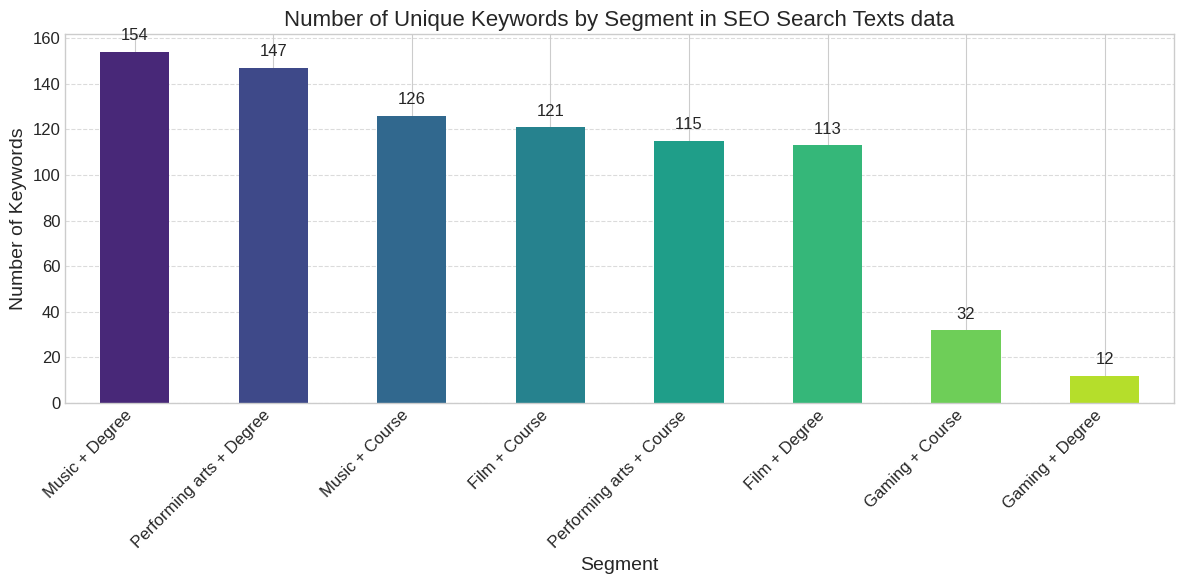

In [126]:
# 1. Bar chart of segment counts (excluding Other, Institution-Specific, etc.)
valid_segments = [
    'Film + Course', 'Film + Degree',
    'Gaming + Course', 'Gaming + Degree',
    'Performing arts + Course', 'Performing arts + Degree',
    'Music + Course', 'Music + Degree'
]

segment_counts = search_keywords_segmented[search_keywords_segmented['Segment'].isin(valid_segments)]['Segment'].value_counts()

plt.figure(figsize=(12, 6))
segment_counts.plot(kind='bar', color=sns.color_palette('viridis', len(segment_counts)))
plt.title('Number of Unique Keywords by Segment in SEO Search Texts data', fontsize=16)
plt.xlabel('Segment', fontsize=14)
plt.ylabel('Number of Keywords', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(segment_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/keywords_by_segment.png')
plt.show()

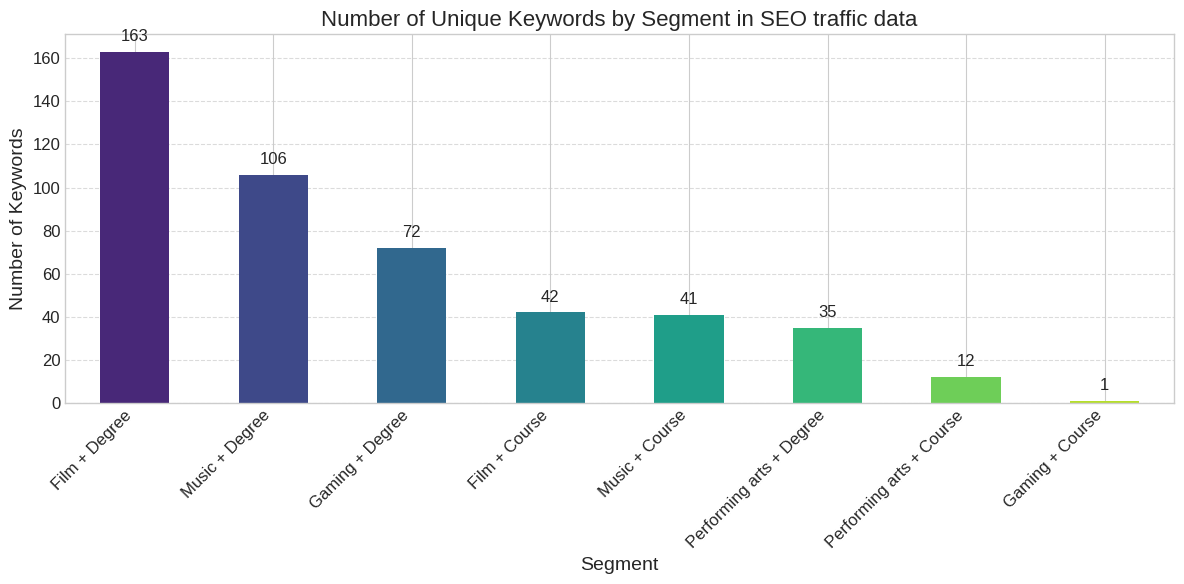

In [127]:
segment_counts = search_domain_traffic_segmented[search_domain_traffic_segmented['Segment'].isin(valid_segments)]['Segment'].value_counts()

plt.figure(figsize=(12, 6))
segment_counts.plot(kind='bar', color=sns.color_palette('viridis', len(segment_counts)))
plt.title('Number of Unique Keywords by Segment in SEO traffic data', fontsize=16)
plt.xlabel('Segment', fontsize=14)
plt.ylabel('Number of Keywords', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(segment_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/keywords_by_segment_domain.png')
plt.show()

### 2.B: The sum of monthly Google searches (grouped by segments)

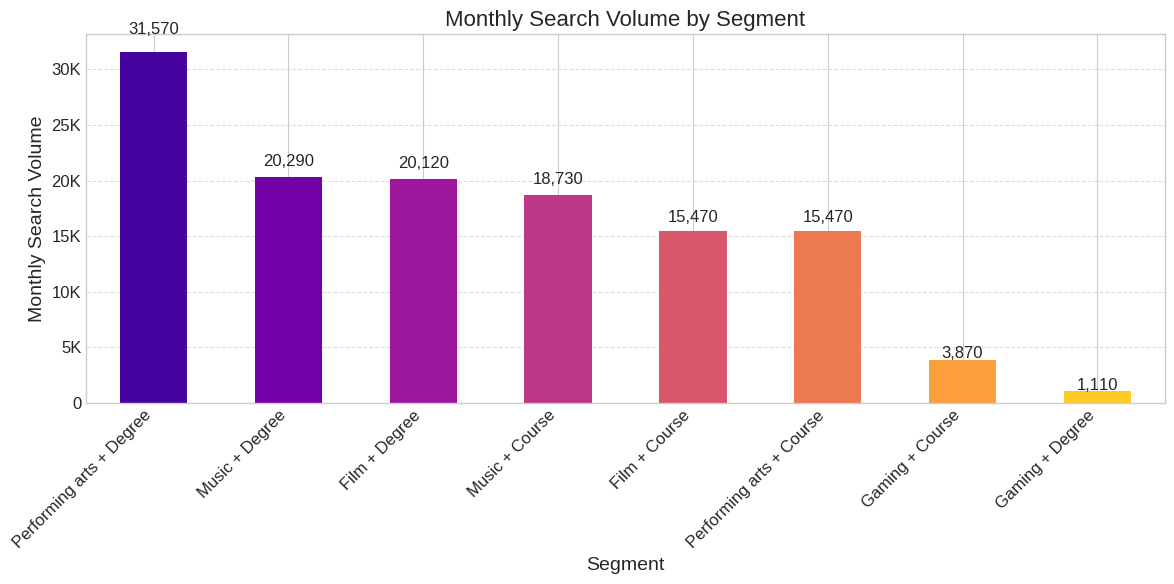

In [128]:
# 2. Bar chart of monthly search volume by segment
segment_volume = search_keywords_segmented[search_keywords_segmented['Segment'].isin(valid_segments)].groupby('Segment')['Monthly Google searches'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
segment_volume.plot(kind='bar', color=sns.color_palette('plasma', len(segment_volume)))
plt.title('Monthly Search Volume by Segment', fontsize=16)
plt.xlabel('Segment', fontsize=14)
plt.ylabel('Monthly Search Volume', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis labels to show thousands with K
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x >= 1000 else f'{int(x)}'))

# Add value labels on top of bars
for i, v in enumerate(segment_volume.values):
    plt.text(i, v * 1.05, f'{int(v):,}', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/monthly_volume_by_segment.png')
plt.show()

In [141]:
segment_volume

,Monthly Google searches
Segment,
Performing arts + Degree,31570
Music + Degree,20290
Film + Degree,20120
Music + Course,18730
Film + Course,15470
Performing arts + Course,15470
Gaming + Course,3870
Gaming + Degree,1110


### Bonus:WordClouds + Most frequent words

In [129]:
def create_segment_wordclouds(segmented_df, valid_segments):
    """
    Create a 2x4 matrix of wordclouds for all segments without saving individual files

    Parameters:
    -----------
    segmented_df : DataFrame
        DataFrame containing 'Keyword' and 'Segment' columns
    valid_segments : list
        List of segment names to visualize

    Returns:
    --------
    fig : matplotlib figure
        The figure containing all wordclouds in a 2x4 matrix
    """
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    # Create figure with appropriate size for 2x4 layout
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    fig.suptitle('Keyword Themes by Segment', fontsize=24, y=0.98)

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Generate wordcloud for each segment
    for i, segment in enumerate(valid_segments):
        # Get keywords for this segment
        segment_keywords = segmented_df[segmented_df['Segment'] == segment]['Keyword'].tolist()

        if segment_keywords:
            # Join all keywords into a single text
            text = ' '.join(segment_keywords)

            # Generate wordcloud
            wordcloud = WordCloud(
                width=800,
                height=400,
                background_color='white',
                max_words=75,
                colormap='viridis',
                collocations=False  # Avoid repeating bigrams
            ).generate(text)

            # Plot on the corresponding subplot
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(segment, fontsize=16)
            axes[i].axis('off')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the super title

    return fig

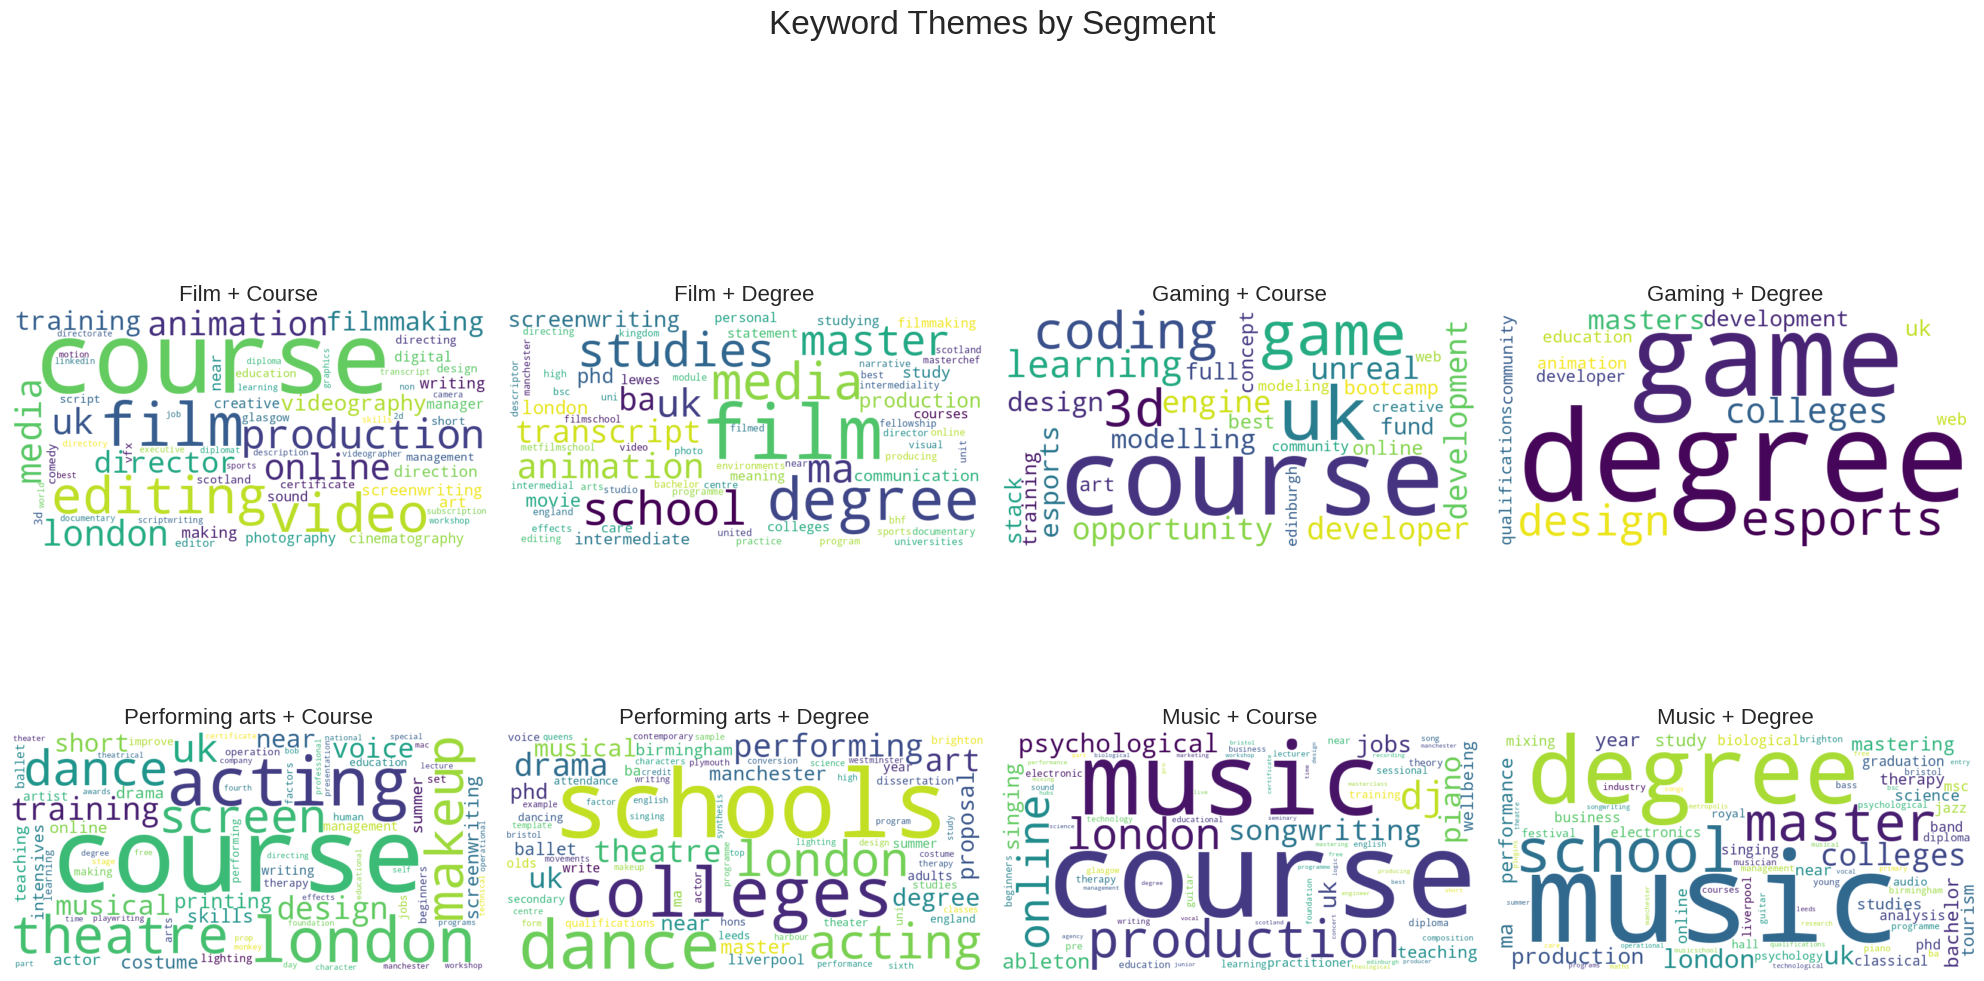

In [130]:
# After you've segmented your keywords
fig = create_segment_wordclouds(search_keywords_segmented, valid_segments)
plt.show()

# If you want to save just the final combined visualization
fig.savefig('bimm_segment_wordclouds.png', dpi=300, bbox_inches='tight')

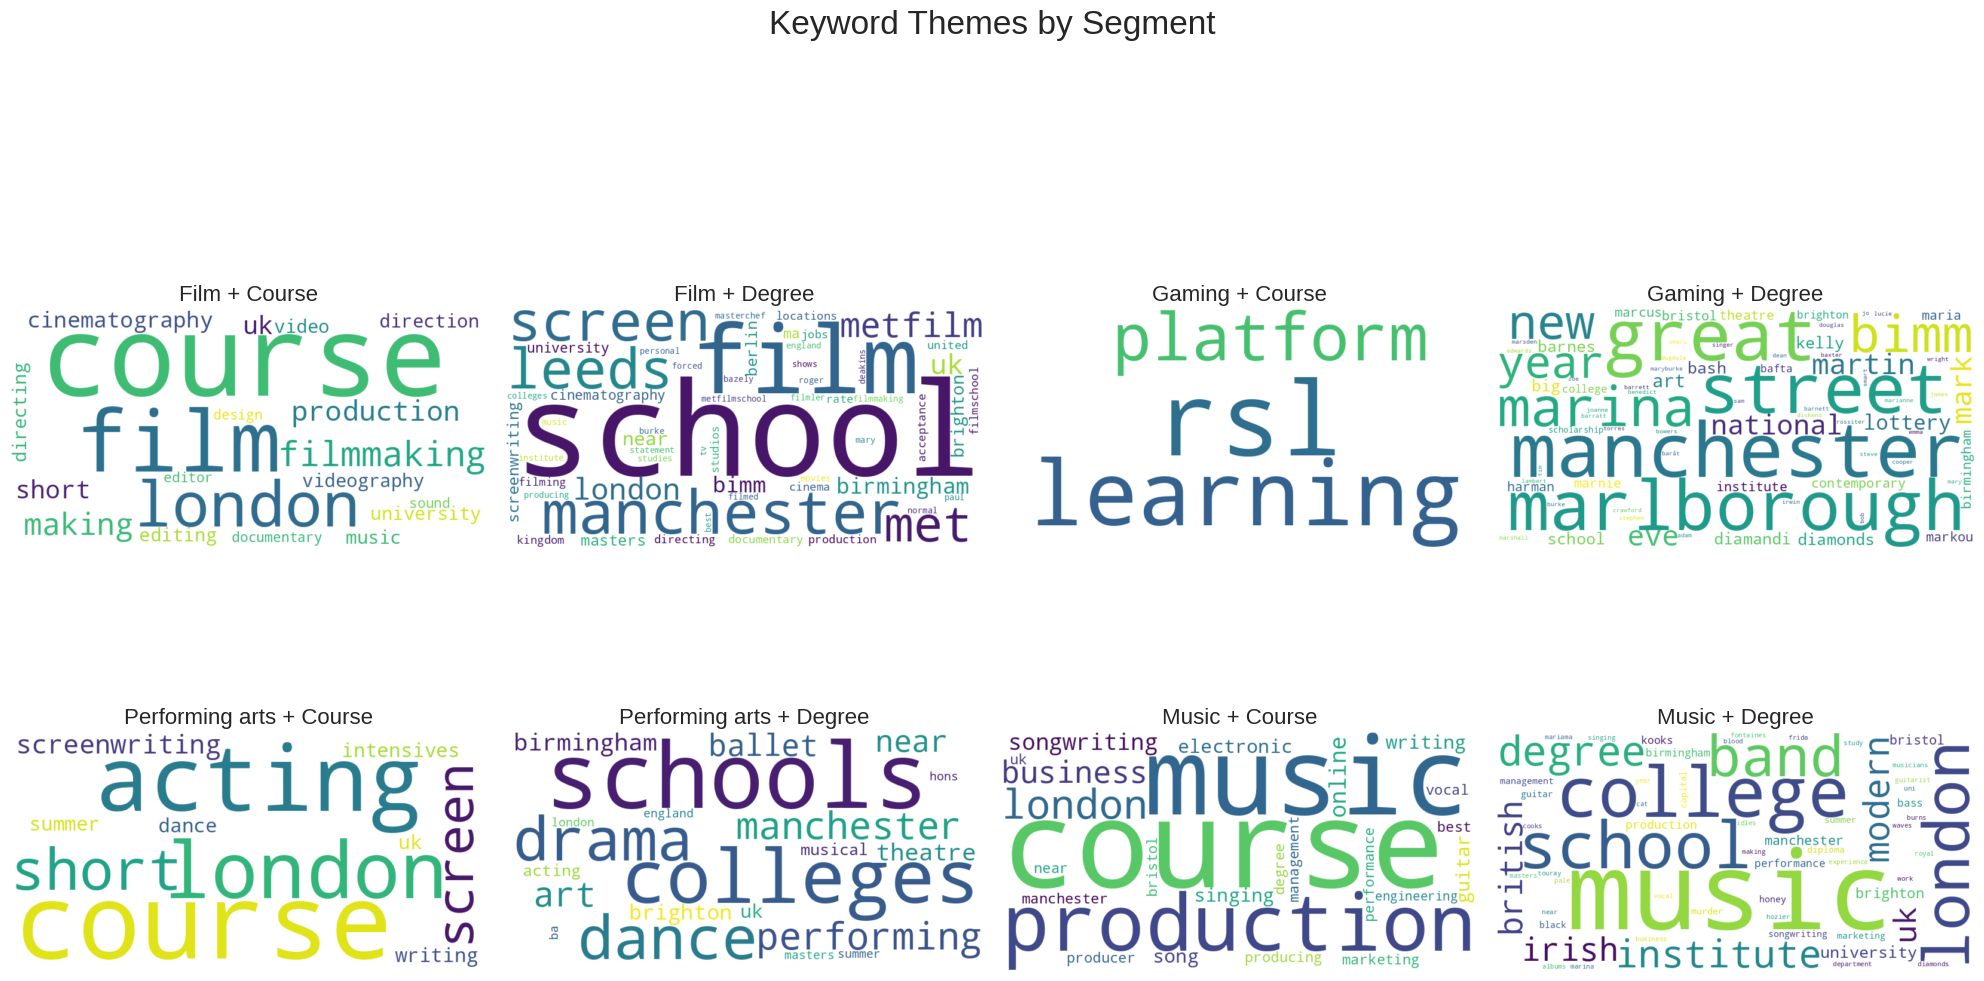

In [131]:
# After you've segmented your keywords
fig = create_segment_wordclouds(search_domain_traffic_segmented, valid_segments)
plt.show()

# If you want to save just the final combined visualization
fig.savefig('bimm_segment_wordclouds.png', dpi=300, bbox_inches='tight')

In [132]:
def visualize_segment_word_frequencies(segmented_df, valid_segments, top_n=15):
    """
    Create a 2x4 matrix visualization of word frequencies for all segments

    Parameters:
    -----------
    segmented_df : DataFrame
        DataFrame containing 'Keyword' and 'Segment' columns
    valid_segments : list
        List of segment names to visualize
    top_n : int, optional
        Number of top words to display for each segment (default: 15)

    Returns:
    --------
    fig : matplotlib figure
        The figure containing all word frequency plots in a 2x4 matrix
    data : dict
        Dictionary with segment names as keys and lists of (word, count) tuples as values
    """
    import matplotlib.pyplot as plt
    from collections import Counter
    import seaborn as sns

    # Create figure with appropriate size for 2x4 layout
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    fig.suptitle('Most Common Words by Segment', fontsize=24, y=0.98)

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Define stopwords to exclude
    stopwords = ['and', 'the', 'for', 'in', 'on', 'to', 'with', 'a', 'of', 'is', 'at', 'an', 'as']

    # Store data for return
    frequency_data = {}

    # Generate word frequency plot for each segment
    for i, segment in enumerate(valid_segments):
        # Get keywords for this segment
        segment_keywords = segmented_df[segmented_df['Segment'] == segment]['Keyword'].tolist()

        if segment_keywords:
            # Tokenize and count words
            all_words = ' '.join(segment_keywords).lower()

            # Count word frequencies, excluding stopwords
            word_counts = Counter()
            for word in all_words.split():
                if word not in stopwords and len(word) > 2:  # Skip very short words and stopwords
                    word_counts[word] += 1

            # Get the top N words
            top_words = word_counts.most_common(top_n)
            frequency_data[segment] = top_words

            if top_words:
                words, counts = zip(*top_words)

                # Create horizontal bar chart (better for word display)
                bars = axes[i].barh(range(len(words)), counts,
                                    color=sns.color_palette('viridis', len(words)))

                # Set y-ticks to word labels
                axes[i].set_yticks(range(len(words)))
                axes[i].set_yticklabels(words)

                # Add title and labels
                axes[i].set_title(segment, fontsize=16)
                axes[i].set_xlabel('Frequency', fontsize=12)

                # Add grid for readability
                axes[i].grid(axis='x', linestyle='--', alpha=0.7)

                # Add count labels to the bars
                for bar in bars:
                    width = bar.get_width()
                    label_position = width - (width * 0.05)  # Position label inside bar
                    axes[i].text(label_position, bar.get_y() + bar.get_height()/2,
                                 f'{int(width)}', va='center', ha='right',
                                 color='white', fontweight='bold', fontsize=9)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the super title

    return fig, frequency_data

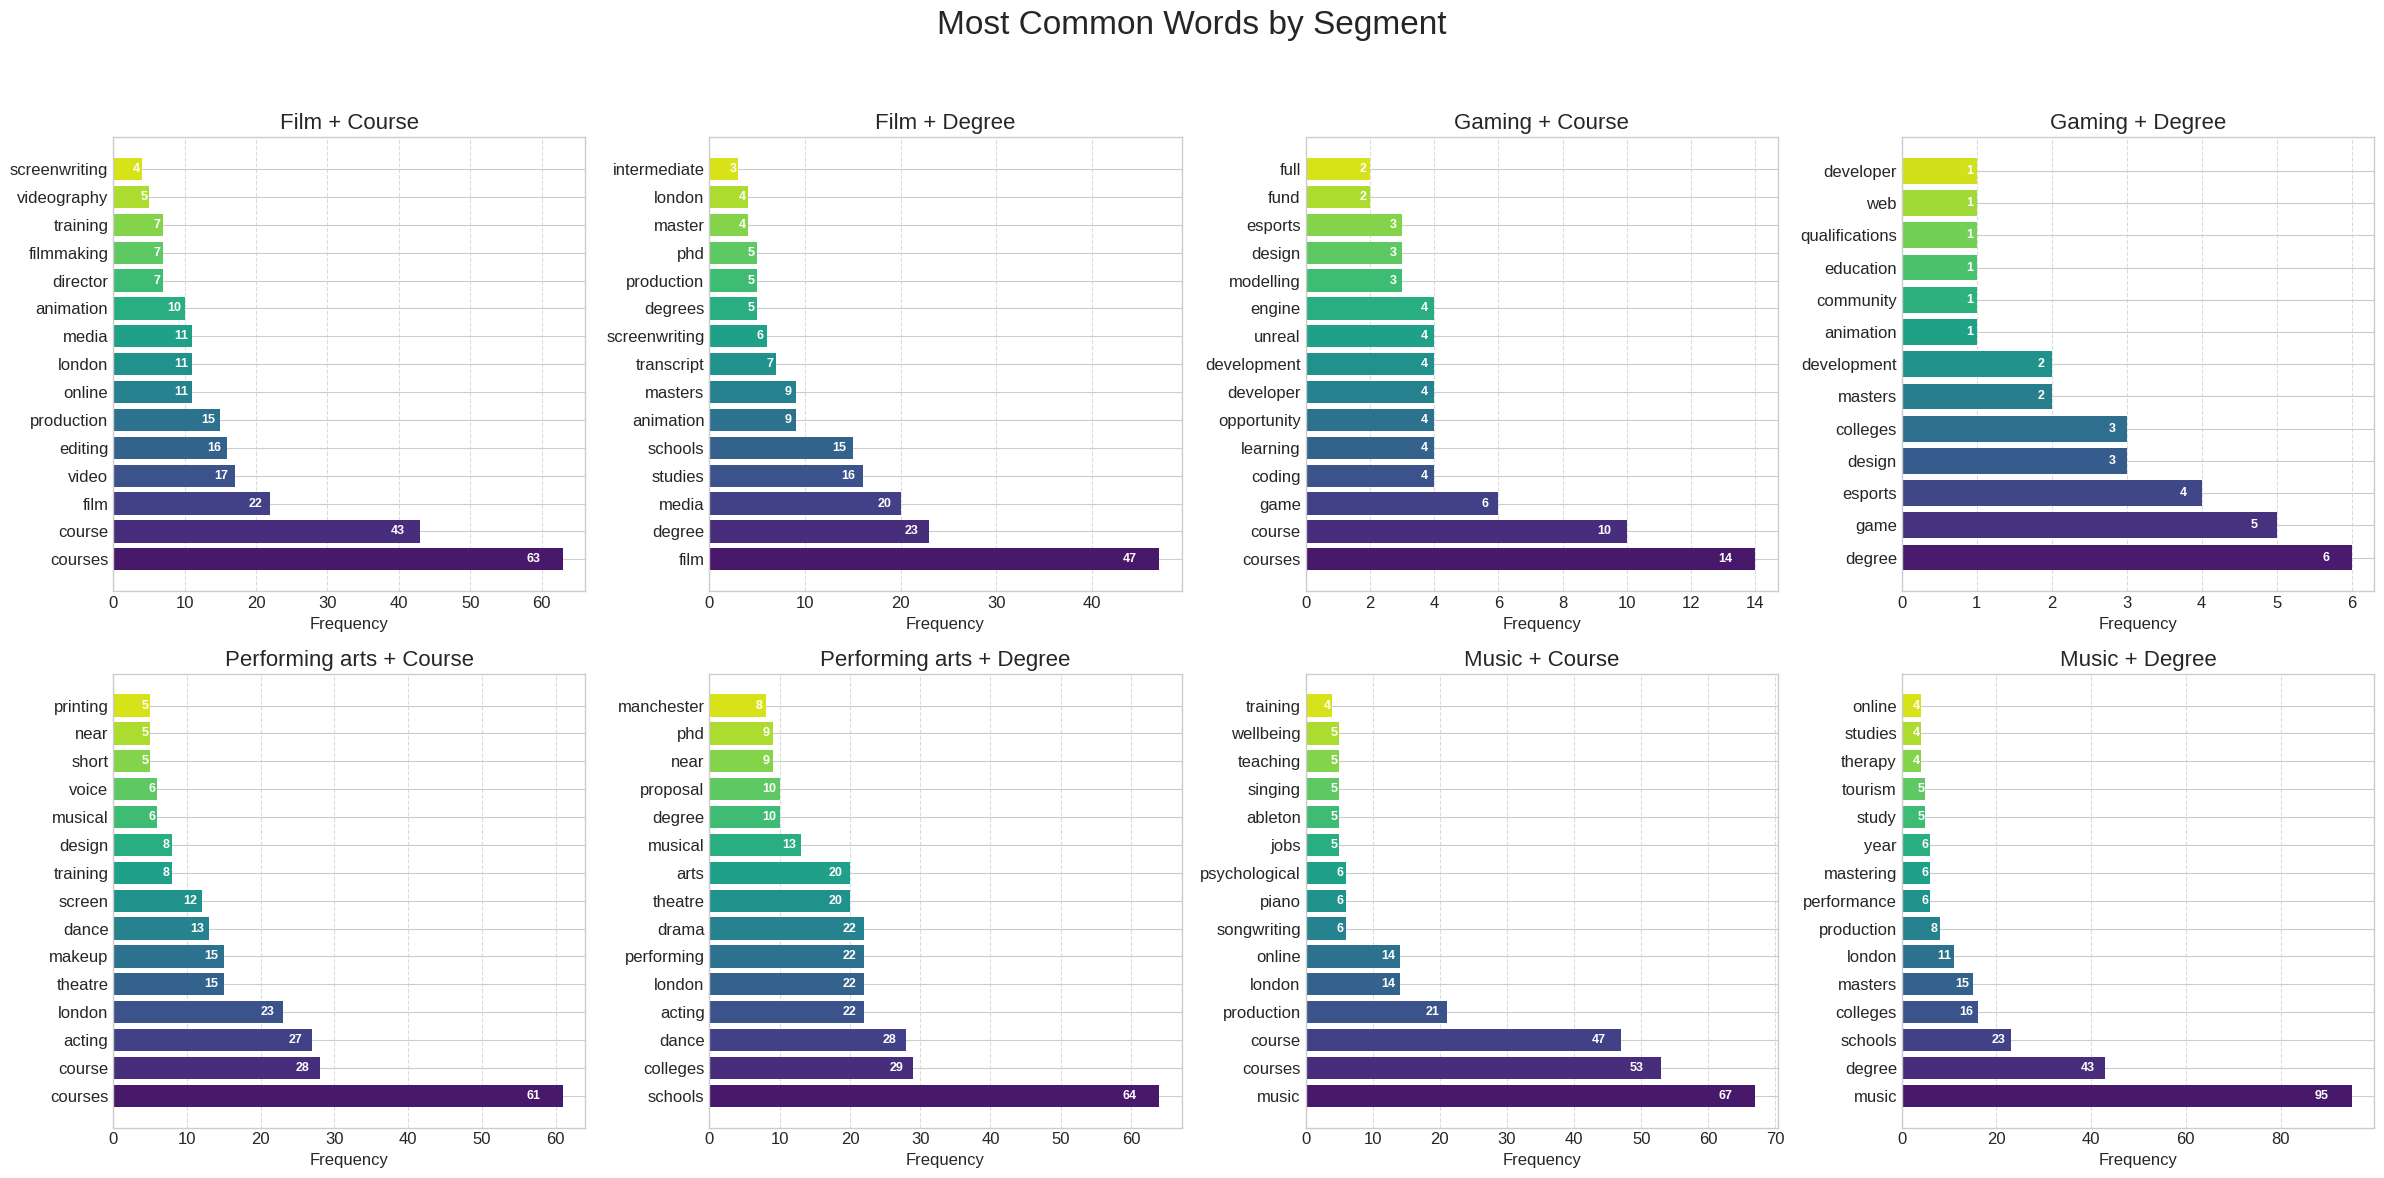

In [133]:
# After you've segmented your keywords
fig, word_freq_data = visualize_segment_word_frequencies(search_keywords_segmented, valid_segments)
plt.show()

# If you want to save just the final combined visualization
fig.savefig('bimm_segment_word_frequencies.png', dpi=300, bbox_inches='tight')

# You can also print the frequency data if needed
#for segment, top_words in word_freq_data.items():
#    print(f"\nMost common words in {segment}:")
#    for word, count in top_words:
#        print(f"  '{word}': {count} occurrences")

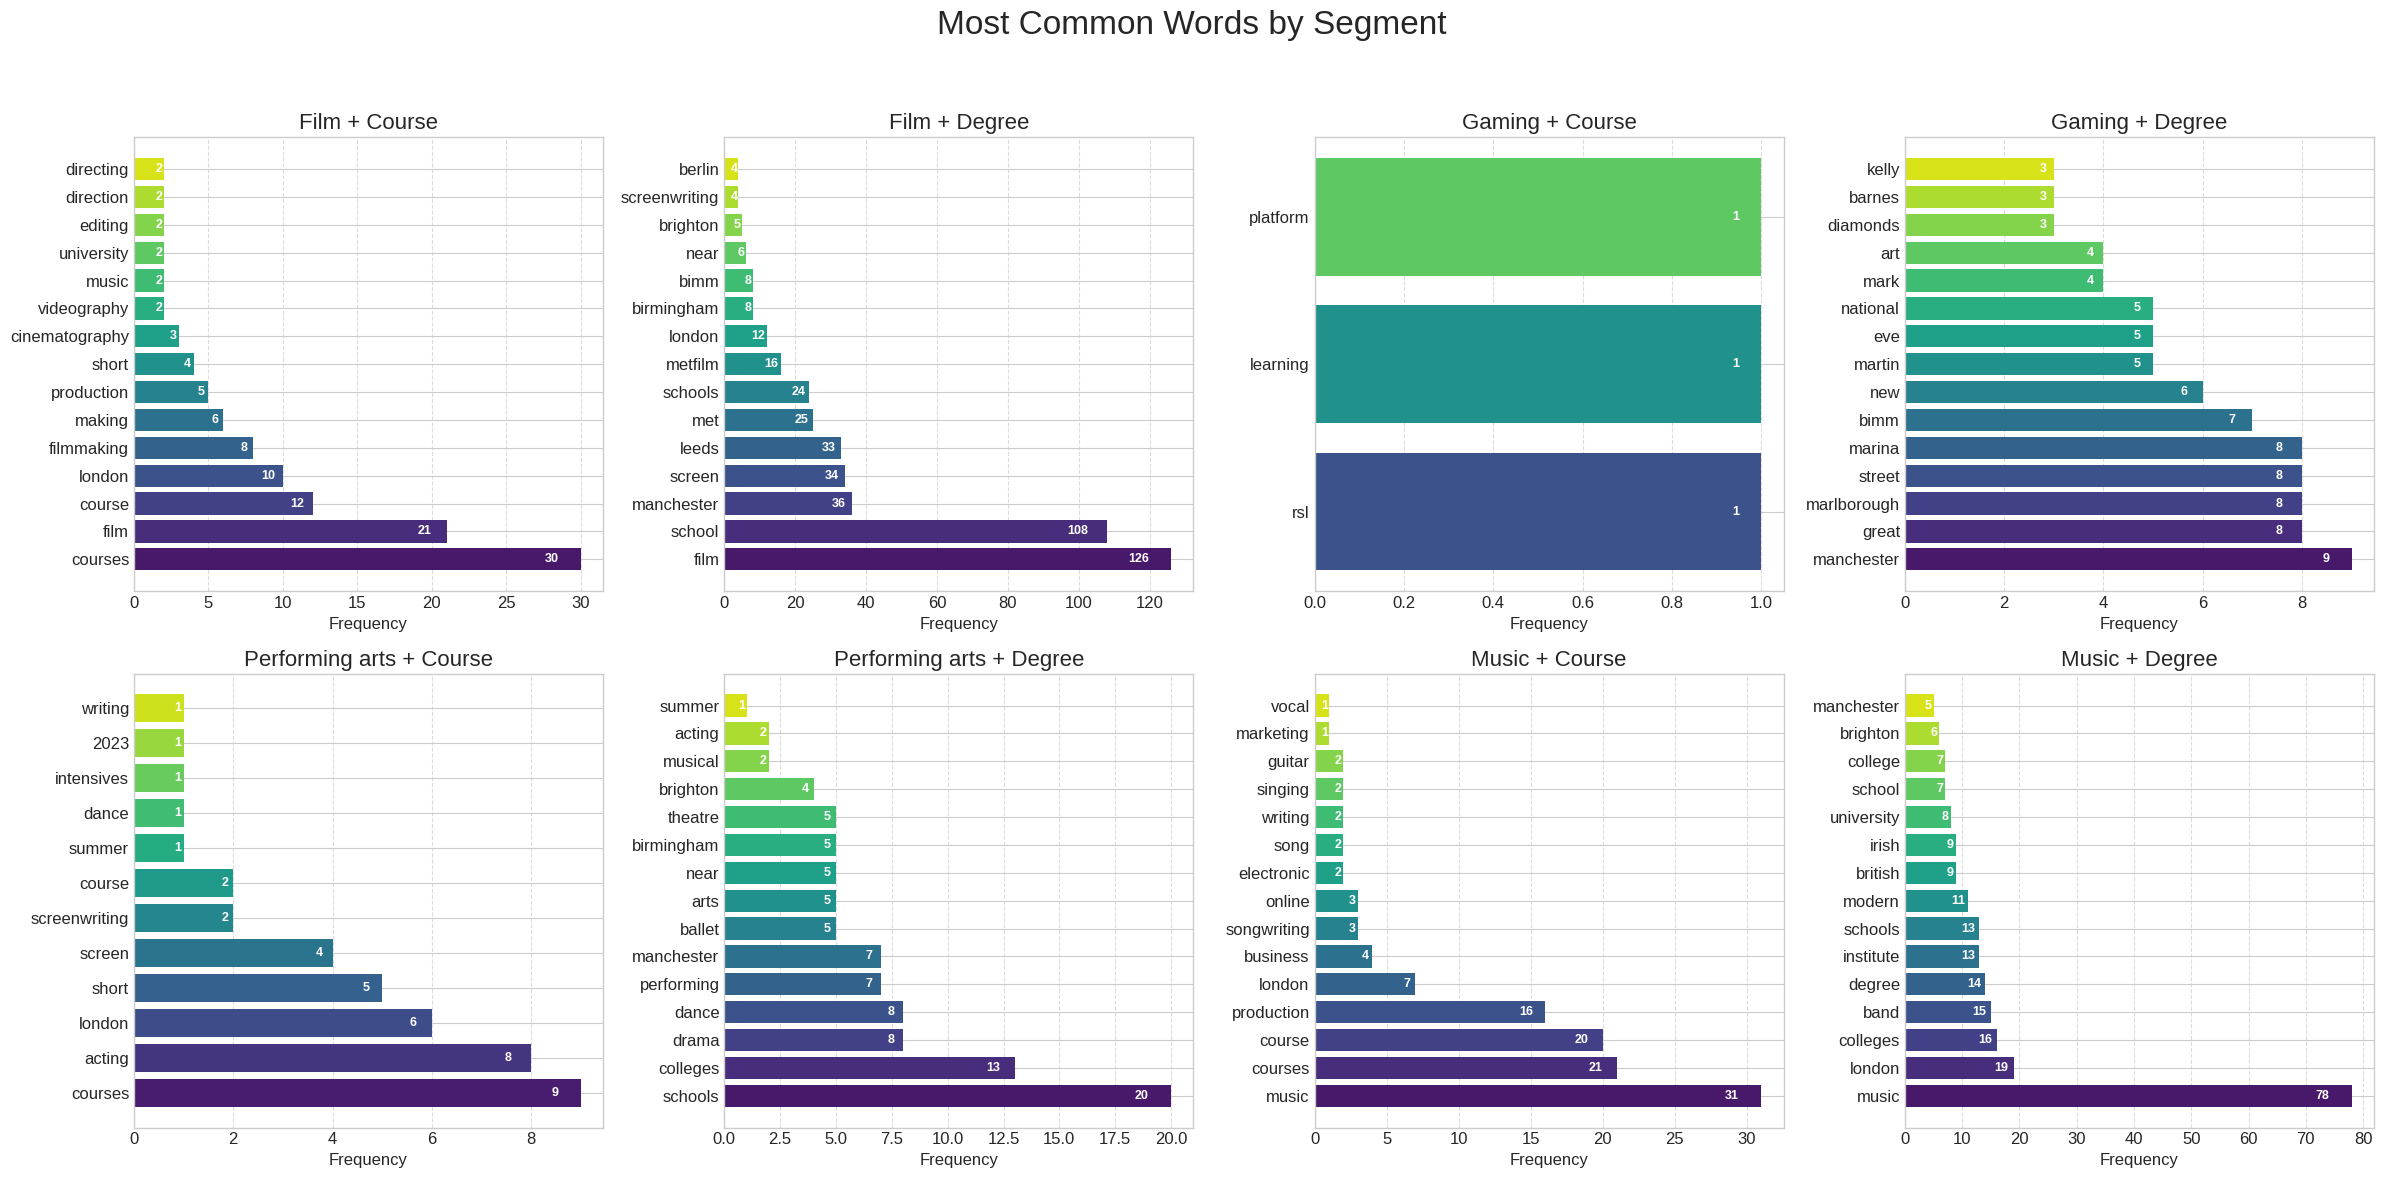

In [134]:
# After you've segmented your keywords
fig, word_freq_data = visualize_segment_word_frequencies(search_domain_traffic_segmented, valid_segments)
plt.show()

# If you want to save just the final combined visualization
fig.savefig('bimm_segment_word_frequencies.png', dpi=300, bbox_inches='tight')

# You can also print the frequency data if needed
#for segment, top_words in word_freq_data.items():
#    print(f"\nMost common words in {segment}:")
#    for word, count in top_words:
#        print(f"  '{word}': {count} occurrences")

### 2.C: BIMM’s current share of SEO traffic measured as a % of overall monthly Google searches, based on BIMM_domains

BIMM's current share of SEO traffic as percentage of overall monthly Google searches:
                     Segment  BIMM_Share_Percent
0              Film + Course            2.869318
1              Film + Degree           41.099773
2            Gaming + Course            0.000000
3            Gaming + Degree            2.259925
5             Music + Course            2.472784
6             Music + Degree            3.377143
9   Performing arts + Course            0.246914
10  Performing arts + Degree            1.234568


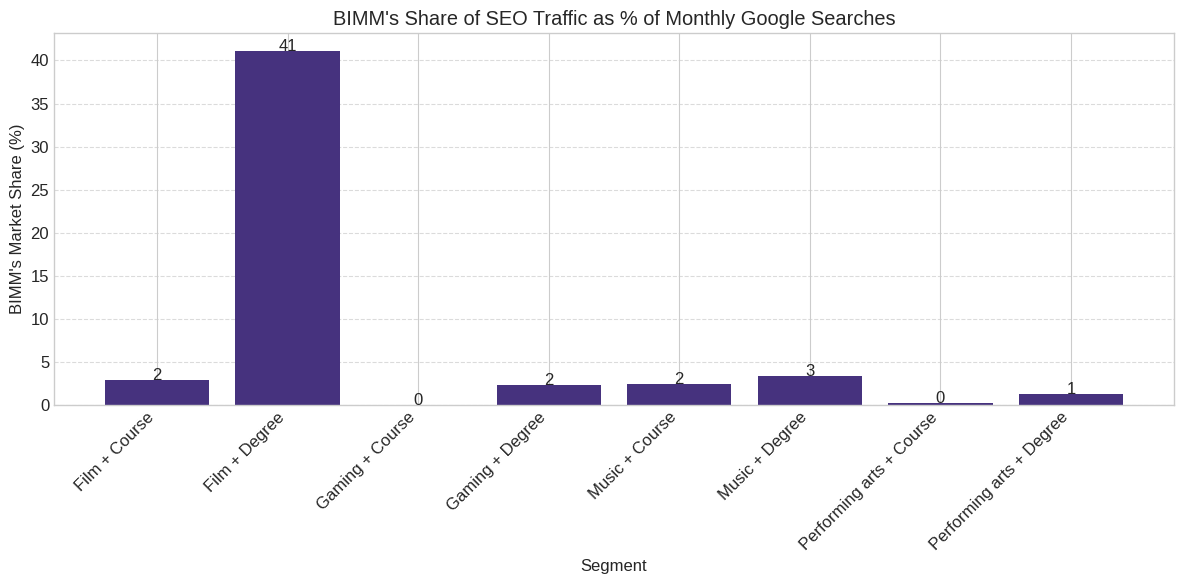

In [135]:
# 2.c BIMM's current share of SEO traffic as % of overall monthly Google searches
# First, calculate total traffic by segment and keyword
total_traffic_by_segment_keyword = search_domain_traffic_segmented.groupby(['Segment', 'Keyword'])['Traffic'].sum().reset_index()

# Then merge with the search keywords dataframe to get the monthly Google searches
traffic_with_searches = total_traffic_by_segment_keyword.merge(
    search_keywords_segmented[['Keyword', 'Monthly Google searches']],
    on='Keyword',
    how='left'
)

# Now calculate BIMM traffic by segment and keyword
bimm_traffic_by_segment_keyword = search_domain_traffic_segmented[search_domain_traffic_segmented['Is_BIMM_Domain'] == True].groupby(
    ['Segment', 'Keyword'])['Traffic'].sum().reset_index()

# Merge BIMM traffic with total traffic and monthly searches
combined_traffic = traffic_with_searches.merge(
    bimm_traffic_by_segment_keyword,
    on=['Segment', 'Keyword'],
    how='left',
    suffixes=('_total', '_bimm')
)

# Fill NaN values with 0 for BIMM traffic (means no BIMM traffic for that keyword)
combined_traffic['Traffic_bimm'] = combined_traffic['Traffic_bimm'].fillna(0)

# Now aggregate by segment
segment_traffic = combined_traffic.groupby('Segment').agg({
    'Traffic_total': 'sum',
    'Traffic_bimm': 'sum',
    'Monthly Google searches': 'sum'
}).reset_index()

# Calculate BIMM's share as percentage
segment_traffic['BIMM_Share_Percent'] = (segment_traffic['Traffic_bimm'] / segment_traffic['Monthly Google searches']) * 100

# Filter to include only the 8 required segments and sort
segment_traffic = segment_traffic[segment_traffic['Segment'].isin(required_segments)]
segment_traffic = segment_traffic.sort_values('Segment')

print("BIMM's current share of SEO traffic as percentage of overall monthly Google searches:")
print(segment_traffic[['Segment', 'BIMM_Share_Percent']])

# Create a bar chart to visualize BIMM's market share
plt.figure(figsize=(12, 6))
plt.bar(segment_traffic['Segment'], segment_traffic['BIMM_Share_Percent'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Segment')
plt.ylabel('BIMM\'s Market Share (%)')
plt.title('BIMM\'s Share of SEO Traffic as % of Monthly Google Searches')

# Add value labels on top of bars
for i, v in enumerate(segment_traffic['BIMM_Share_Percent'].values):
    plt.text(i, v, f'{int(v):,}', ha='center', fontsize=12)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 2.D: BIMM’s biggest competitor(s) in terms of traffic


BIMM's top 10 competitors by total traffic:
                             Domain   Traffic
32            https://www.ed.ac.uk/  636805.0
44     https://www.liverpool.ac.uk/  258404.0
25          https://www.arts.ac.uk/  236112.0
63   https://www.westminster.ac.uk/  196472.0
52       https://www.salford.ac.uk/  177028.0
19               https://uel.ac.uk/  176847.0
42  https://www.leedsbeckett.ac.uk/  160029.0
35          https://www.gold.ac.uk/  146374.0
37          https://www.hull.ac.uk/  141563.0
26           https://www.aru.ac.uk/  141410.0


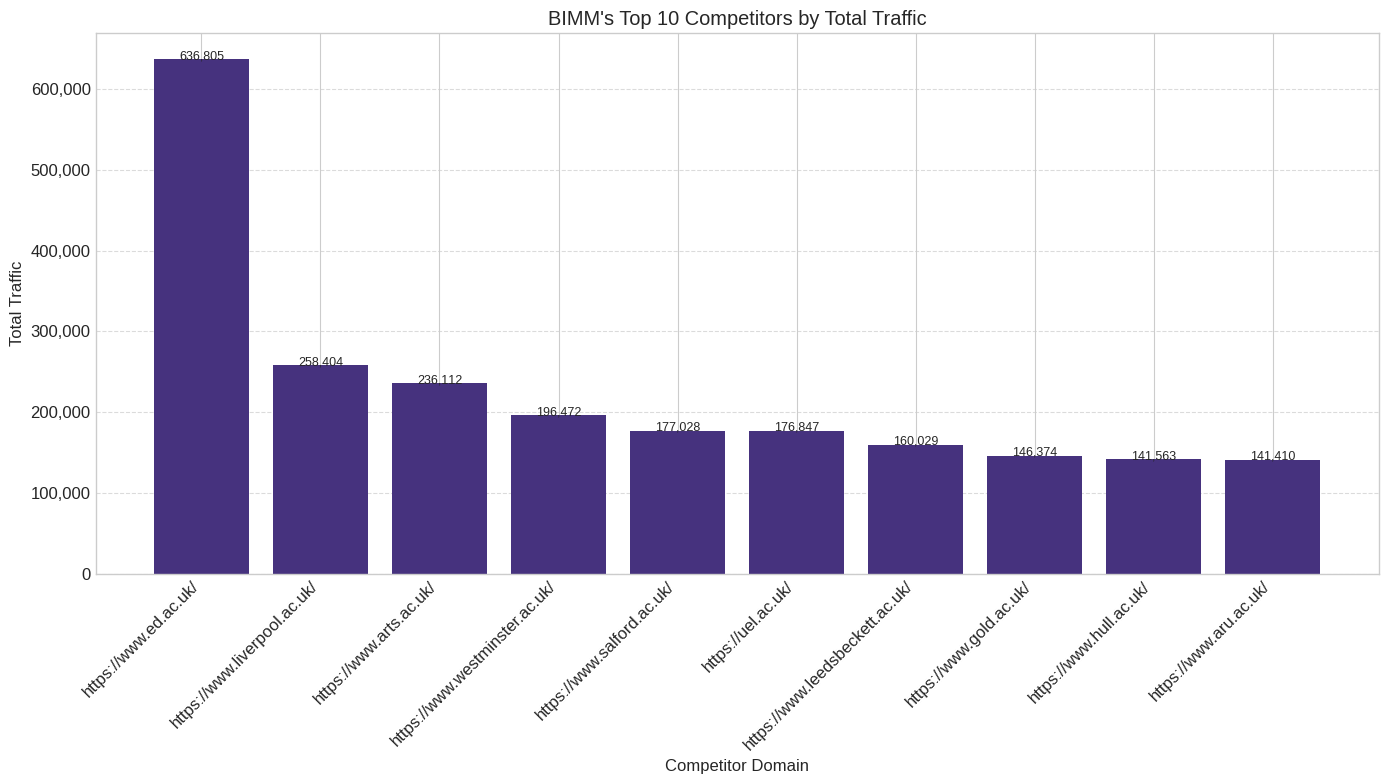

In [136]:
# 2.d BIMM's biggest competitor in terms of traffic - SIMPLIFIED
# Identify non-BIMM domains (competitors)
competitor_traffic = search_domain_traffic_segmented[search_domain_traffic_segmented['Is_BIMM_Domain'] == False]

# Group by domain to get total traffic per competitor
domain_traffic = competitor_traffic.groupby('Domain')['Traffic'].sum().reset_index()

# Sort to find top competitors
top_competitors = domain_traffic.sort_values('Traffic', ascending=False).head(10)

print("\nBIMM's top 10 competitors by total traffic:")
print(top_competitors)

# Create a bar chart for top competitors
plt.figure(figsize=(14, 8))
bars = plt.bar(top_competitors['Domain'], top_competitors['Traffic'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Competitor Domain')
plt.ylabel('Total Traffic')
plt.title('BIMM\'s Top 10 Competitors by Total Traffic')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add traffic values on top of each bar
for i, bar in enumerate(bars):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 5,
        f"{int(top_competitors['Traffic'].iloc[i]):,}",
        ha='center',
        fontsize=9
    )

plt.show()

### 3: *Identify a list of Search Texts where BIMM currently generates no traffic from SEO, and prioritise the top fifty Search Texts that you recommend that BIMM should start to target*

In [137]:
# 3. Identify Search Texts where BIMM currently generates no traffic from SEO
# First, get all keywords with BIMM traffic
bimm_traffic_keywords = search_domain_traffic_segmented[search_domain_traffic_segmented['Is_BIMM_Domain'] == True]['Keyword'].unique()

# Then identify keywords in our segments that have no BIMM traffic
no_bimm_traffic_keywords = search_keywords_segmented[
    (search_keywords_segmented['Segment'].isin(required_segments)) &
    (~search_keywords_segmented['Keyword'].isin(bimm_traffic_keywords))
]

# Now, let's prioritize these keywords
# We'll use monthly searches as a measure of opportunity
prioritized_keywords = no_bimm_traffic_keywords.sort_values('Monthly Google searches', ascending=False)

# To refine this further, let's calculate an "opportunity score" based on search volume and competitor traffic
# First, get competitor traffic for these keywords
competitor_keyword_traffic = search_domain_traffic_segmented[
    (search_domain_traffic_segmented['Is_BIMM_Domain'] == False) &
    (search_domain_traffic_segmented['Keyword'].isin(no_bimm_traffic_keywords['Keyword']))
].groupby('Keyword')['Traffic'].sum().reset_index()

# Merge with our no-traffic keywords
opportunity_keywords = prioritized_keywords.merge(
    competitor_keyword_traffic,
    on='Keyword',
    how='left'
)

# Fill NaN values with 0 for competitor traffic
opportunity_keywords['Traffic'] = opportunity_keywords['Traffic'].fillna(0)

# Calculate opportunity score:
# Higher monthly searches and lower competitor traffic = better opportunity
# Normalize both metrics to 0-1 scale
opportunity_keywords['normalized_searches'] = opportunity_keywords['Monthly Google searches'] / opportunity_keywords['Monthly Google searches'].max()
opportunity_keywords['normalized_comp_traffic'] = 1 - (opportunity_keywords['Traffic'] / (opportunity_keywords['Traffic'].max() + 1))  # Adding 1 to avoid division by zero

# Create opportunity score (weight searches higher than competitive difficulty)
opportunity_keywords['opportunity_score'] = (0.7 * opportunity_keywords['normalized_searches']) + (0.3 * opportunity_keywords['normalized_comp_traffic'])

# Get top 50 keywords by opportunity score
top_50_opportunities = opportunity_keywords.sort_values('opportunity_score', ascending=False).head(50)

print("Top 50 Search Texts BIMM should target (currently no traffic):")
top_50_opportunities[['Keyword', 'Segment', 'Monthly Google searches', 'Traffic', 'opportunity_score']]

Top 50 Search Texts BIMM should target (currently no traffic):


,Keyword,Segment,Monthly Google searches,Traffic,opportunity_score
0,media studies,Film + Degree,2400,7.0,0.991829
1,ma film,Film + Degree,2400,48.0,0.943969
2,junior music course,Music + Course,1600,31.0,0.730480
4,training for dance,Performing arts + Course,1300,1.0,0.677999
3,dance schools,Performing arts + Degree,1300,6.0,0.672163
6,drama schools,Performing arts + Degree,1300,6.0,0.672163
5,video editing course,Film + Course,1300,30.0,0.644147
7,ma characters,Performing arts + Degree,1300,34.0,0.639478
9,phd media,Film + Degree,1000,0.0,0.591667
8,film studies,Film + Degree,1000,8.0,0.582328


In [142]:
top_50_opportunities[['Keyword', 'Segment', 'Monthly Google searches', 'Traffic', 'opportunity_score']].to_csv('untapped_opportunities.csv', index=False)

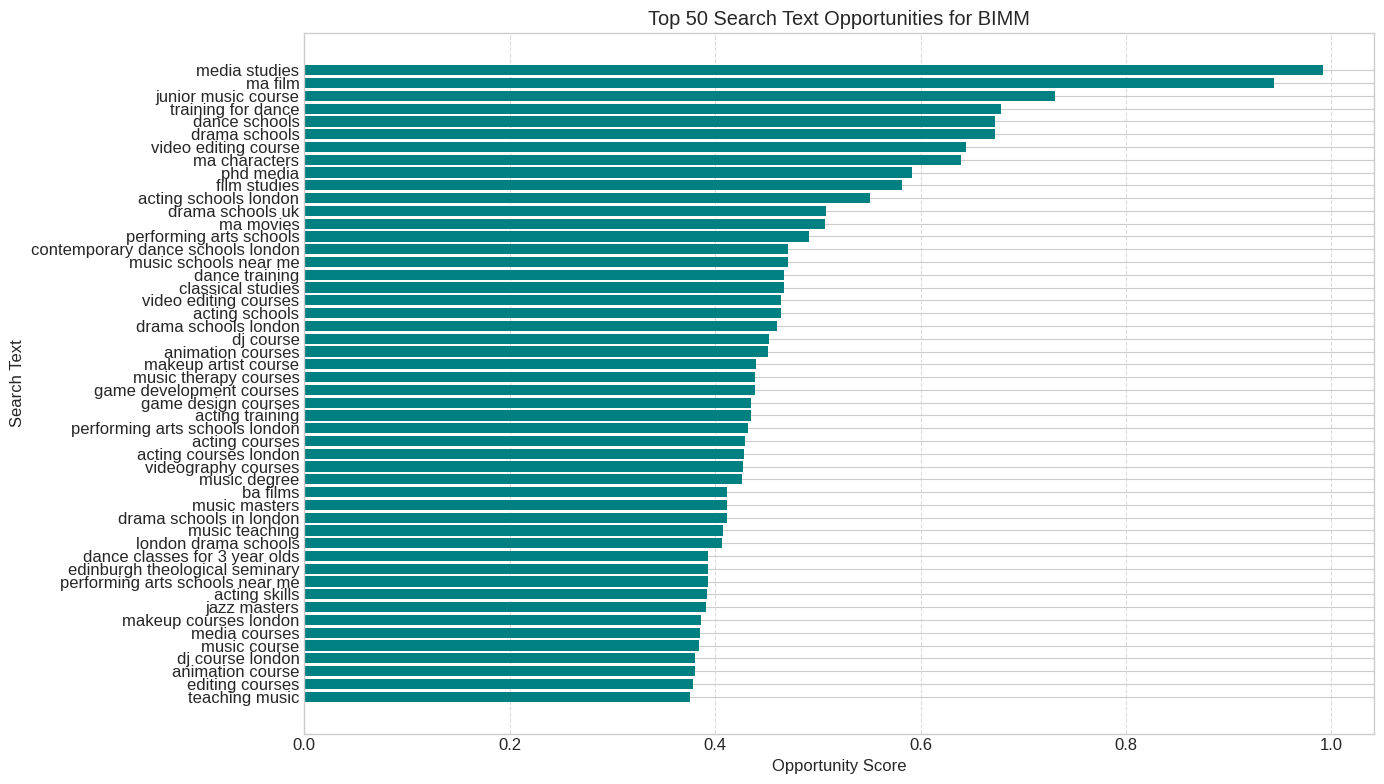

In [138]:
# Create a visualization for the top 10 opportunities
top_50 = top_50_opportunities
top_50 = top_50.sort_values('opportunity_score', ascending=True)
plt.figure(figsize=(14, 8))
plt.barh(top_50['Keyword'], top_50['opportunity_score'], color='teal')
plt.xlabel('Opportunity Score')
plt.ylabel('Search Text')
plt.title('Top 50 Search Text Opportunities for BIMM')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Save the top 50 opportunities to a CSV file for the presentation
top_50_opportunities[['Keyword', 'Segment', 'Monthly Google searches', 'Traffic', 'opportunity_score']].to_csv(
    'untapped_opportunities.csv', index=False,
    columns=['Keyword', 'Segment', 'Monthly Google searches', 'Traffic', 'opportunity_score'],
    header=['Keyword', 'Segment', 'Monthly Searches', 'Competitor Traffic', 'Opportunity Score']
)


### Summary Stats

In [139]:
def create_seo_segmentation_summary(search_keywords_segmented, valid_segments):
    """
    Generate a professionally formatted summary of SEO segmentation results
    with improved visualizations.

    Parameters:
    -----------
    search_keywords_segmented : DataFrame
        DataFrame containing the segmented keywords with 'Keyword', 'Segment',
        and 'Monthly Google searches' columns
    valid_segments : list
        List of valid segment names (BIMM-relevant segments)

    Returns:
    --------
    summary_data : dict
        Dictionary containing summary statistics and segment details
    figs : dict
        Dictionary containing the generated matplotlib figures
    """

    # Create a dictionary to store all summary data
    summary_data = {}
    figs = {}

    # Calculate overall statistics
    total_keywords = len(search_keywords_segmented)
    bimm_relevant = len(search_keywords_segmented[search_keywords_segmented['Segment'].isin(valid_segments)])
    institution_specific = len(search_keywords_segmented[search_keywords_segmented['Segment'] == 'Institution-Specific'])
    academic_generic = len(search_keywords_segmented[search_keywords_segmented['Segment'] == 'Academic-Generic'])
    non_educational = len(search_keywords_segmented[search_keywords_segmented['Segment'] == 'Non-Educational'])
    other = len(search_keywords_segmented[search_keywords_segmented['Segment'] == 'Other'])

    # Store overall statistics
    summary_data['overall'] = {
        'total_keywords': total_keywords,
        'bimm_relevant': bimm_relevant,
        'bimm_relevant_pct': bimm_relevant/total_keywords*100,
        'institution_specific': institution_specific,
        'institution_specific_pct': institution_specific/total_keywords*100,
        'academic_generic': academic_generic,
        'academic_generic_pct': academic_generic/total_keywords*100,
        'non_educational': non_educational,
        'non_educational_pct': non_educational/total_keywords*100,
        'other': other,
        'other_pct': other/total_keywords*100
    }

    # Generate segment-specific summary
    segment_summary = search_keywords_segmented[
        search_keywords_segmented['Segment'].isin(valid_segments)
    ].groupby('Segment').agg(
        Keywords=('Keyword', 'count'),
        TotalSearchVolume=('Monthly Google searches', 'sum')
    ).sort_values('TotalSearchVolume', ascending=False)

    segment_summary['AverageSearchVolume'] = segment_summary['TotalSearchVolume'] / segment_summary['Keywords']
    segment_summary['PercentOfTotal'] = segment_summary['Keywords'] / bimm_relevant * 100

    # Store segment summary
    summary_data['segment_summary'] = segment_summary

    # Create enhanced pie chart
    fig1 = plt.figure(figsize=(12, 10))
    gs = GridSpec(2, 2, width_ratios=[3, 2], height_ratios=[3, 1])

    # Main pie chart
    ax1 = fig1.add_subplot(gs[0, 0])

    labels = ['BIMM-relevant', 'Institution-Specific', 'Academic-Generic', 'Non-Educational', 'Other']
    sizes = [bimm_relevant, institution_specific, academic_generic, non_educational, other]

    # Use a more visually appealing color palette
    colors = sns.color_palette('viridis', len(labels))

    # Create exploded pie chart with the first slice (BIMM-relevant) slightly separated
    explode = (0.05, 0, 0, 0, 0)

    wedges, texts, autotexts = ax1.pie(
        sizes,
        labels=None,  # We'll add custom legend
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        explode=explode,
        shadow=False,
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    # Customize the percentage text
    for autotext in autotexts:
        autotext.set_color('white')

    # Equal aspect ratio ensures the pie chart is circular
    ax1.axis('equal')
    ax1.set_title('Distribution of Keywords by Category', fontsize=20, pad=20)

    # Custom legend
    ax1.legend(
        wedges,
        [f"{label} ({size:,})" for label, size in zip(labels, sizes)],
        title="Categories",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        fontsize=12
    )

    # Add a summary table for the segments
    ax2 = fig1.add_subplot(gs[1, :])
    ax2.axis('tight')
    ax2.axis('off')

    # Create summary table data
    table_data = [
        ["Category", "Keywords", "Percentage"],
        ["BIMM-relevant", f"{bimm_relevant:,}", f"{bimm_relevant/total_keywords*100:.1f}%"],
        ["Institution-Specific", f"{institution_specific:,}", f"{institution_specific/total_keywords*100:.1f}%"],
        ["Academic-Generic", f"{academic_generic:,}", f"{academic_generic/total_keywords*100:.1f}%"],
        ["Non-Educational", f"{non_educational:,}", f"{non_educational/total_keywords*100:.1f}%"],
        ["Other", f"{other:,}", f"{other/total_keywords*100:.1f}%"],
        ["Total", f"{total_keywords:,}", "100.0%"]
    ]

    # Create the table
    table = ax2.table(
        cellText=table_data,
        cellLoc='center',
        loc='center',
        colWidths=[0.4, 0.3, 0.3]
    )

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    # Add styling to header row
    for j, cell in enumerate(table._cells[(0, j)] for j in range(3)):
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4472C4')

    # Add styling to total row
    for j, cell in enumerate(table._cells[(6, j)] for j in range(3)):
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#E6E6E6')

    plt.tight_layout()
    figs['category_distribution'] = fig1

    # Create a visually enhanced segment summary figure
    fig2 = plt.figure(figsize=(14, 10))
    gs2 = GridSpec(2, 1, height_ratios=[1, 3])

    # Stacked horizontal bar for search volume
    ax3 = fig2.add_subplot(gs2[0])

    # Prepare data for the bar chart
    segments = segment_summary.index
    keywords = segment_summary['Keywords'].values
    volumes = segment_summary['TotalSearchVolume'].values
    avg_volumes = segment_summary['AverageSearchVolume'].values

    # Create a horizontal bar chart for the total search volume
    bars = ax3.barh(
        segments,
        volumes,
        color=sns.color_palette('viridis', len(segments)),
        alpha=0.8
    )

    # Add volume labels to the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax3.text(
            width + (width * 0.01),  # Position slightly right of the bar
            bar.get_y() + bar.get_height()/2,
            f"{int(volumes[i]):,}",
            va='center',
            fontsize=10,
            fontweight='bold'
        )

    ax3.set_title('Total Monthly Search Volume by Segment', fontsize=16)
    ax3.set_xlabel('Monthly Searches', fontsize=12)
    ax3.grid(axis='x', linestyle='--', alpha=0.7)

    # Add a formatted table for the segment details
    ax4 = fig2.add_subplot(gs2[1])
    ax4.axis('tight')
    ax4.axis('off')

    # Format the data for the table
    table_data = [
        ["Segment", "Keywords", "Total Search Volume", "Avg. Search Volume", "% of BIMM Relevant"],
    ]

    for segment in segment_summary.index:
        row = segment_summary.loc[segment]
        table_data.append([
            segment,
            f"{int(row['Keywords']):,}",
            f"{int(row['TotalSearchVolume']):,}",
            f"{row['AverageSearchVolume']:.1f}",
            f"{row['PercentOfTotal']:.1f}%"
        ])

    # Add total row
    table_data.append([
        "Total",
        f"{bimm_relevant:,}",
        f"{segment_summary['TotalSearchVolume'].sum():,.0f}",
        f"{segment_summary['TotalSearchVolume'].sum() / bimm_relevant:.1f}",
        "100.0%"
    ])

    # Create the table
    segment_table = ax4.table(
        cellText=table_data,
        cellLoc='center',
        loc='center',
        colWidths=[0.3, 0.15, 0.2, 0.2, 0.15]
    )

    # Style the table
    segment_table.auto_set_font_size(False)
    segment_table.set_fontsize(12)
    segment_table.scale(1, 1.8)

    # Add styling to header row
    for j, cell in enumerate(segment_table._cells[(0, j)] for j in range(5)):
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4472C4')

    # Add styling to total row
    for j, cell in enumerate(segment_table._cells[(len(table_data)-1, j)] for j in range(5)):
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#E6E6E6')

    # Highlight top segments
    for i in range(1, min(4, len(segment_summary)+1)):  # Highlight top 3
        for j in range(5):
            cell = segment_table._cells[(i, j)]
            cell.set_facecolor('#EBF1DE')  # Light green

    plt.tight_layout()
    figs['segment_details'] = fig2

    return summary_data, figs

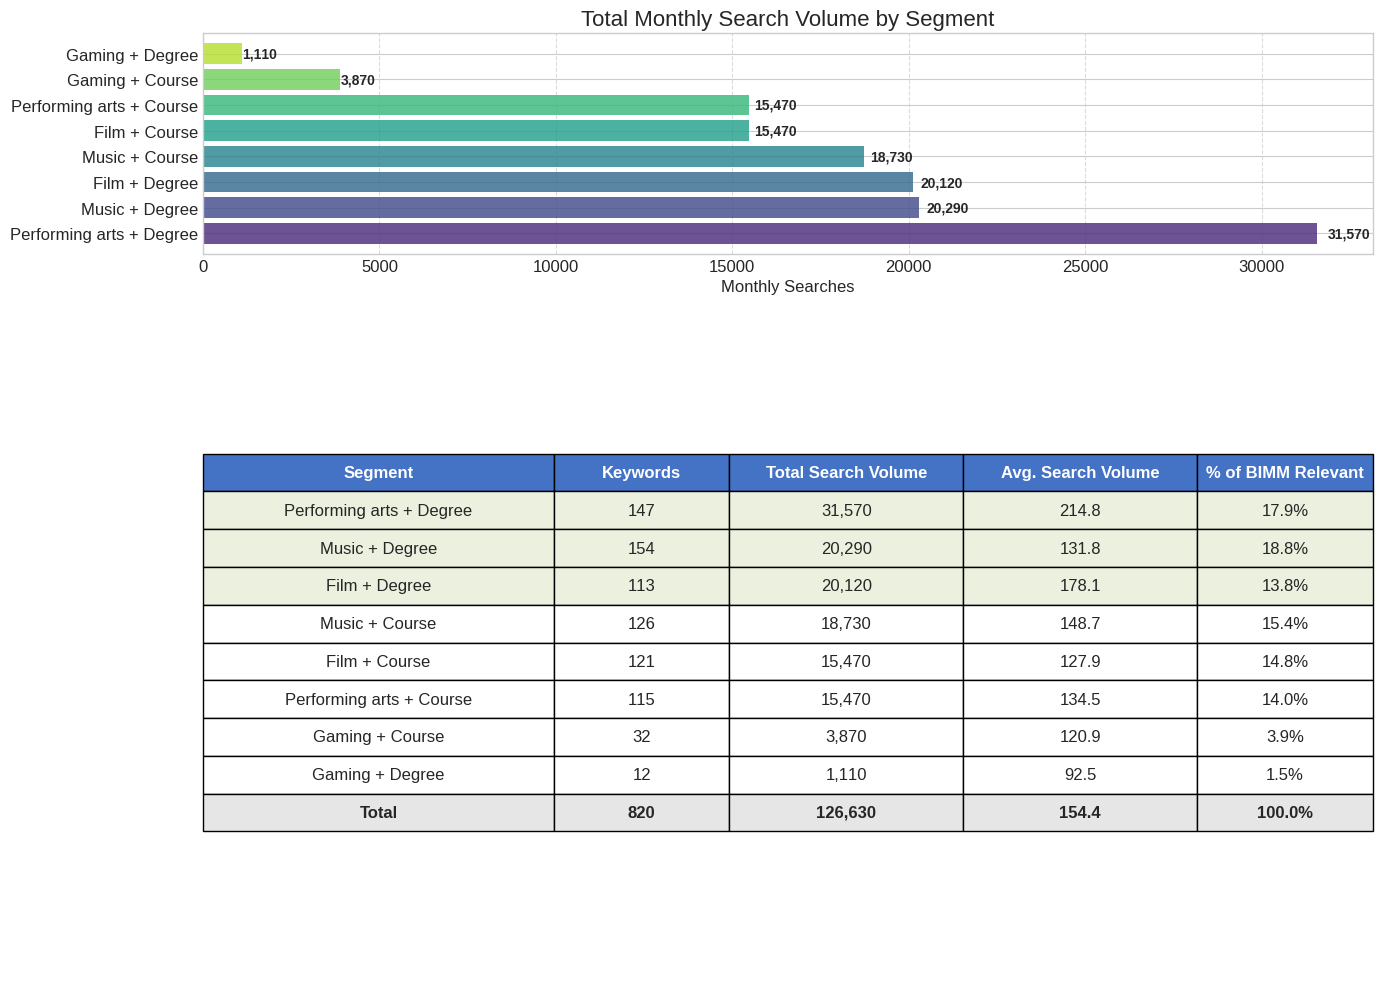

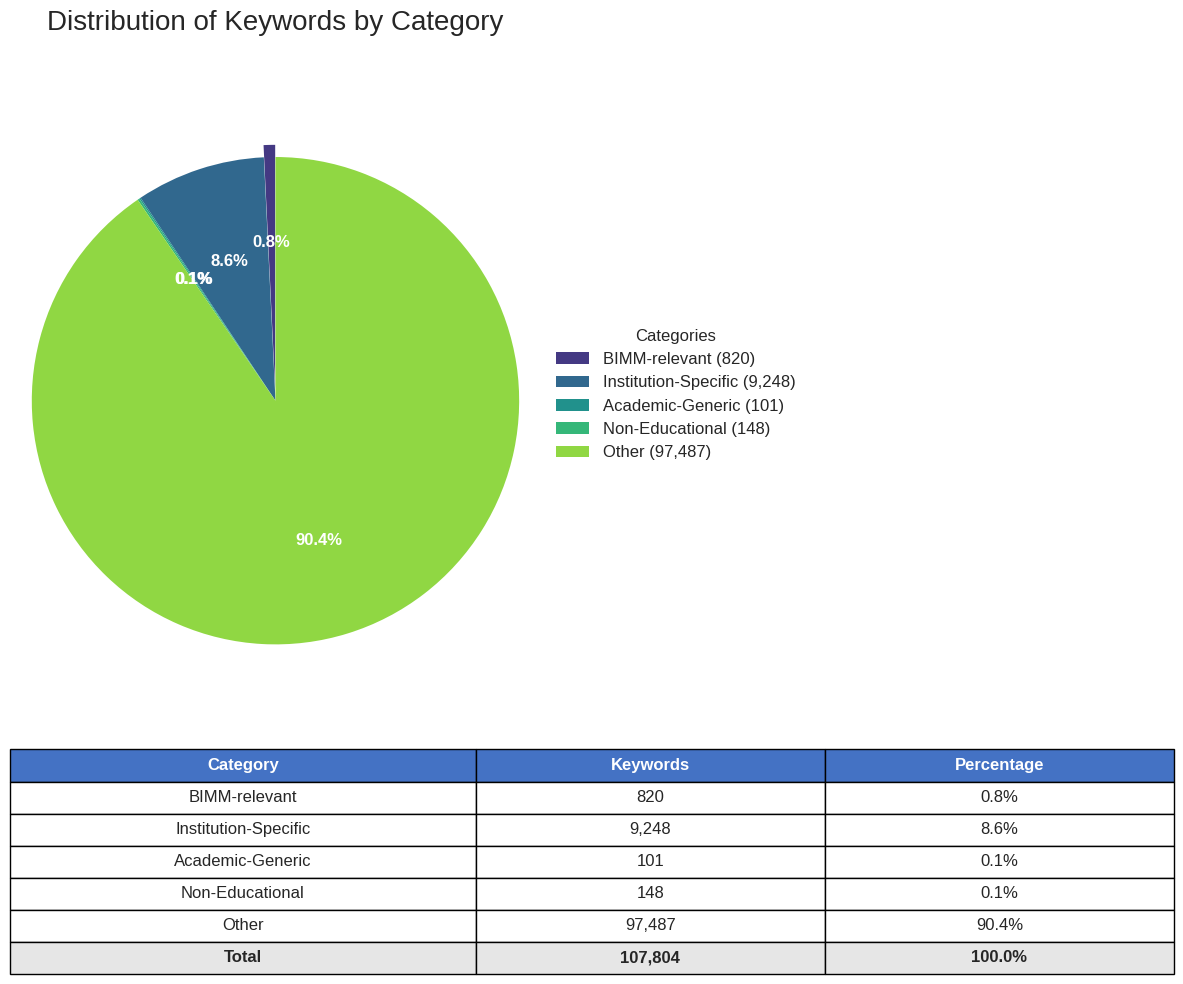

<Figure size 640x480 with 0 Axes>

Total keywords analyzed: 107,804
BIMM-relevant keywords: 820 (0.8%)


In [140]:
# After you've segmented your keywords
summary_data, figures = create_seo_segmentation_summary(search_keywords_segmented, valid_segments)

# Display the category distribution figure
plt.figure(figures['category_distribution'].number)
plt.show()

# Display the segment details figure
plt.figure(figures['segment_details'].number)
plt.show()

# Save the figures if needed
figures['category_distribution'].savefig('bimm_category_distribution.png', dpi=300, bbox_inches='tight')
figures['segment_details'].savefig('bimm_segment_details.png', dpi=300, bbox_inches='tight')

# Print a summary of key findings
print(f"Total keywords analyzed: {summary_data['overall']['total_keywords']:,}")
print(f"BIMM-relevant keywords: {summary_data['overall']['bimm_relevant']:,} ({summary_data['overall']['bimm_relevant_pct']:.1f}%)")